# Configure Application

In [1]:
%%configure -f
{"executorMemory": "2G",
 "driverMemory": "1G",
 "executorCores": 1,
 "numExecutors": 3,
 "conf": {
     "spark.dynamicAllocation.enabled": "false",
     "spark.sql.parquet.enableVectorizedReader": "false",
     "spark.pyspark.python": "python3",
     "spark.pyspark.virtualenv.enabled": "true",
     "spark.pyspark.virtualenv.type": "native",
     "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv"
 }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
367,application_1681238170162_0365,pyspark,idle,Link,Link,None,
375,application_1681238170162_0373,pyspark,idle,Link,Link,None,


# Load csv File into Application

In [2]:
df = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/final_clean_data.csv")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
384,application_1681238170162_0382,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Create Parquet Files for Scale

In [3]:
#### Read the CSV file into a DataFrame
df_transform = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/final_clean_data.csv")

#### Write the DataFrame to a Parquet file
df_transform.write.parquet("s3://msbx5420-spr23/citibike/final_cleaned_pq.parquet")

#### Upload Parquet File
df = spark.read.format("parquet").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/final_cleaned_pq.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
path s3://msbx5420-spr23/citibike/final_cleaned_pq.parquet already exists.
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/readwriter.py", line 1140, in parquet
    self._jwrite.parquet(path)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/utils.py", line 196, in deco
    raise converted from None
pyspark.sql.utils.AnalysisException: path s3://msbx5420-spr23/citibike/final_cleaned_pq.parquet already exists.



In [4]:
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|          end_lat|           end_lng|member_casual|trip_duration|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+-------------+
|3B40831921DAD6C1| classic_bike|2022-04-08 10:20:55|2022-04-08 10:25:29|   JC Medical Center|           JC011|            Grand St|         JC102|40.71653978099194| -74.0496379137039|40.71517767732029|-74.03768330812454|       member|          5.0|
|69C

# Reconfigure Application for Scale

#### change cell below from markdown to code, then run to scale up application


%%configure -f
{"executorMemory": "3G",
 "driverMemory": "1G",
 "executorCores": 1,
 "numExecutors": 30,
 "conf": {
     "spark.dynamicAllocation.enabled": "false",
     "spark.sql.parquet.enableVectorizedReader": "false",
     "spark.pyspark.python": "python3",
     "spark.pyspark.virtualenv.enabled": "true",
     "spark.pyspark.virtualenv.type": "native",
     "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv"
 }
} 

# Install Packages & Import libraries

In [5]:
sc.install_pypi_package('pandas')
sc.install_pypi_package('folium')
sc.install_pypi_package('boto3')
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('seaborn')
sc.install_pypi_package('numpy')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Test Application Speed (Last Cell Shows Execution Time)

In [6]:
import time 

start_time = time.time()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, explode, sequence, udf, col, sum, array, unix_timestamp, round, hour, dayofweek, minute, struct, concat, lit, desc, row_number, concat_ws, when, date_format
from pyspark.sql.types import FloatType
from pyspark.sql.window import Window
import math, time, folium, boto3
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql.functions import to_date, count, avg

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Profiling & Cleaning

In [8]:
# Check the dimensions of the data
print("Number of rows:",df.count())
print("Number of columns:",len(df.columns))
print('________Schema____________')

# print the data frame's schema
df.printSchema()
print('_________Null Value Check_________')

# double check for null values (data was preprocessing and nulls were removed in the preprocessing)
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows: 854162
Number of columns: 14
________Schema____________
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- trip_duration: double (nullable = true)

_________Null Value Check_________
+-------+-------------+----------+--------+------------------+----------------+----------------+--------------+---------+---------+-------+-------+-------------+-------------+
|ride_id|rideable_type|started_at|ended_at|start_station_name|start_station_id|end_station_name|e

# General Analysis of Bike Types

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

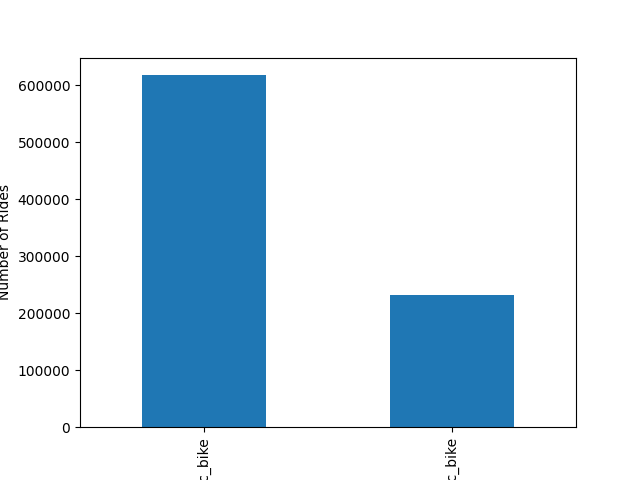

In [9]:
# Create the Bike Type Dataframe
bike_type = df.groupBy('rideable_type').agg(count('*').alias('num_rides')).filter(df['rideable_type'] != 'docked_bike')
bike_type = bike_type.sort(desc('num_rides'))

# Display details of Bike Type Dataframe
bike_type.show()

# Create barplot function
def barplot(df, col, yname=None):
   
    # Convert to pandas DataFrame 
    pd_df = df.toPandas()
    
    # Making plot 
    pd_df.plot(kind='bar', x=col, y='num_rides', legend=False)
    plt.ylabel('Number of Rides')
    plt.xlabel('Bike Type')
    plt.show()

# Display Bar Chart    
barplot(bike_type,'rideable_type')
%matplot plt

# General Analysis of Member Type

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

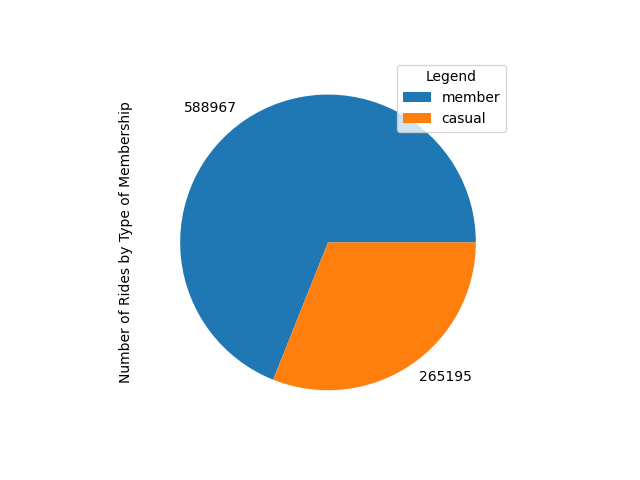

In [10]:
# Create the user type dataframe
user_type = df.groupBy('member_casual').agg(count('*')).alias('user_count')

# Display the user type data
user_type.show()

# Create the pieplot function
def pieplot(df, col, yname=None):
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count(1)', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.toPandas()
    
    # Making plot 
    pd_df.plot(kind='pie', x=col, y='count(1)', \
           labels=pd_df[col[1]], legend=True)
    plt.legend(title='Legend', labels=['member','casual'], loc='upper right')
    plt.ylabel('Number of Rides by Type of Membership')
    plt.show()

# Display the pieplot pie chart
pieplot(user_type, ['member_casual','count(1)'])
%matplot plt

# Insights Objectives

### 1. Determine and examine patterns of the most popular bike routes in the dataset

In [11]:
route_counts = df.groupby(['start_station_name', 'end_station_name','start_lat','start_lng','end_lat','end_lng']).agg(count('ride_id').alias('num_rides')).filter(col("start_station_name") != col("end_station_name"))

most_popular_routes = route_counts.sort(desc('num_rides'))

nyc_coords = [40.7128,-74.0060]
map = folium.Map(location=nyc_coords, zoom_start=13)

for row in most_popular_routes.take(100):
    start_station = row['start_station_name']
    start_coords = [float(row['start_lat']),float(row['start_lng'])]
    end_station = row['end_station_name']
    end_coords = [float(row['end_lat']), float(row['end_lng'])]
    
    start_marker = folium.Marker(location=start_coords, tooltip=start_station, icon=folium.Icon(color='red'))
    end_marker = folium.Marker(location=end_coords, tooltip=end_station, icon=folium.Icon(color='red'))
    start_marker.add_to(map)
    end_marker.add_to(map)
    
    folium.PolyLine(locations=[start_coords, end_coords], color='blue', weight=1.5, opacity=1).add_to(map)

# Save the map as an HTML file
map.save("revisedmap.html")

# Upload the HTML file to S3 Bucket
s3 = boto3.client("s3")
bucket_name = "msbx5420-spr23"
s3.upload_file("revisedmap.html", bucket_name, "citibike/revisedmap.html")
print('File Uploaded Successfully')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

File Uploaded Successfully

#### Chart Function for General Analysis of the most popular routes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

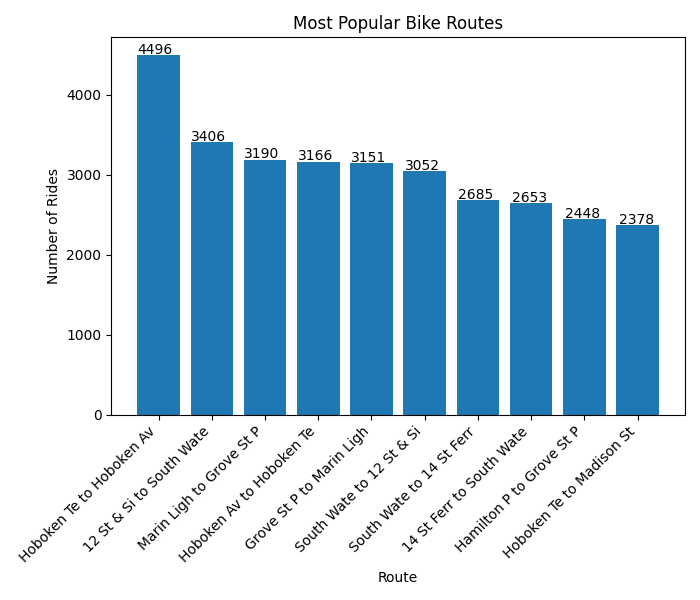

In [12]:

route_counts = df.groupby(['start_station_name', 'end_station_name','start_lat','start_lng','end_lat','end_lng']).agg(count('ride_id').alias('num_rides')).filter(col("start_station_name") != col("end_station_name"))

# Concatenate the start and end station names into a single string and abbreviate to 10 characters
route_counts = route_counts.withColumn('route', concat_ws(' to ', col('start_station_name').substr(1, 10), col('end_station_name').substr(1, 10)))

# Sort the routes by number of rides and select the top 10
most_popular_routes = route_counts.sort(col('num_rides').desc()).limit(10).toPandas()

# Create a bar chart of the most popular routes
fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(most_popular_routes['route'], most_popular_routes['num_rides'])
ax.set_xlabel('Route')
ax.set_ylabel('Number of Rides')
ax.set_title('Most Popular Bike Routes')
plt.xticks(rotation=45, ha='right')
#Add the counts on top the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.tight_layout()
plt.show()
%matplot plt


#### Chart Function for Member Analysis of the most popular routes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

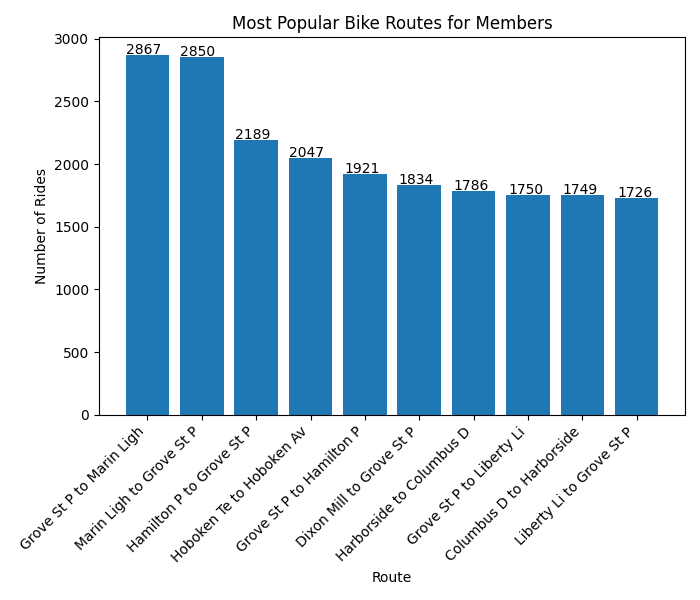

In [13]:
# most popular routes for members 

route_counts = df[df['member_casual'] == 'member']

route_counts = route_counts.groupby(['start_station_name', 'end_station_name','start_lat','start_lng','end_lat','end_lng']).agg(count('ride_id').alias('num_rides')).filter(col("start_station_name") != col("end_station_name"))

# Concatenate the start and end station names into a single string and abbreviate to 10 characters
route_counts = route_counts.withColumn('route', concat_ws(' to ', col('start_station_name').substr(1, 10), col('end_station_name').substr(1, 10)))


# Sort the routes by number of rides and select the top 10
most_popular_routes = route_counts.sort(col('num_rides').desc()).limit(10).toPandas()

route_counts.show(5)

# Create a bar chart of the most popular routes
fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(most_popular_routes['route'], most_popular_routes['num_rides'])
ax.set_xlabel('Route')
ax.set_ylabel('Number of Rides')
ax.set_title('Most Popular Bike Routes for Members')
plt.xticks(rotation=45, ha='right')
#Add the counts on top the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.tight_layout()
plt.show()
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

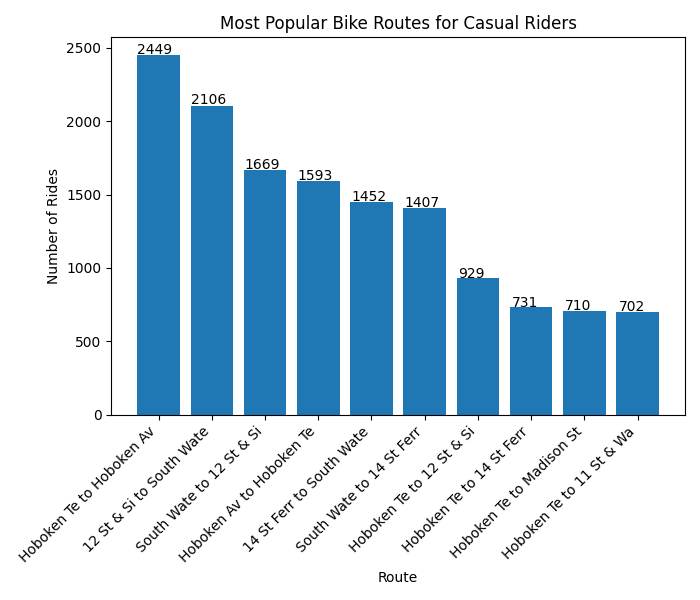

In [14]:
# most popular routes for casual riders
route_counts2 = df[df['member_casual'] == 'casual']

route_counts2 = route_counts2.groupby(['start_station_name', 'end_station_name','start_lat','start_lng','end_lat','end_lng']).agg(count('ride_id').alias('num_rides')).filter(col("start_station_name") != col("end_station_name"))

# Concatenate the start and end station names into a single string and abbreviate to 10 characters
route_counts2 = route_counts2.withColumn('route', concat_ws(' to ', col('start_station_name').substr(1, 10), col('end_station_name').substr(1, 10)))


# Sort the routes by number of rides and select the top 10
most_popular_routes2 = route_counts2.sort(col('num_rides').desc()).limit(10).toPandas()

# Create a bar chart of the most popular routes
fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(most_popular_routes2['route'], most_popular_routes2['num_rides'])
ax.set_xlabel('Route')
ax.set_ylabel('Number of Rides')
ax.set_title('Most Popular Bike Routes for Casual Riders')
plt.xticks(rotation=45, ha='right')
#Add the counts on top the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.tight_layout()
plt.show()
%matplot plt

#### Average Ride Length

In [15]:
df.select(sum('trip_duration')/count('ride_id')).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------+
|(sum(trip_duration) / count(ride_id))|
+-------------------------------------+
|                    8.373821359414256|
+-------------------------------------+

#### Average Ride Length by Top Stations

In [16]:
route_counts = df.groupby(['start_station_name', 'end_station_name','start_lat','start_lng','end_lat','end_lng']).agg(count('ride_id').alias('num_rides')).filter(col("start_station_name") != col("end_station_name"))

trip_dur_station = df.groupBy('start_station_name','end_station_name').sum('trip_duration').sort(desc('sum(trip_duration)'))
trip_dur_station = trip_dur_station.withColumnRenamed('sum(trip_duration)', 'trip_dur')

trip_dur_all = trip_dur_station.join(route_counts, on = ['start_station_name','end_station_name'])
trip_dur_all = trip_dur_all.sort(desc('num_rides'))
trip_dur_all=trip_dur_all.drop('start_lat','start_lng','end_lat','end_lng')
trip_dur_all.withColumn('avg_ride', trip_dur_all.trip_dur/trip_dur_all.num_rides).show(5)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------+---------+------------------+
|  start_station_name|    end_station_name|trip_dur|num_rides|          avg_ride|
+--------------------+--------------------+--------+---------+------------------+
|Hoboken Terminal ...|Hoboken Ave at Mo...| 45185.0|     4496|10.050044483985765|
|12 St & Sinatra Dr N|South Waterfront ...| 35404.0|     3406| 10.39459776864357|
|    Marin Light Rail|       Grove St PATH| 16970.0|     3190|5.3197492163009406|
|Hoboken Ave at Mo...|Hoboken Terminal ...| 31910.0|     3166|10.078963992419457|
|       Grove St PATH|    Marin Light Rail| 19427.0|     3151| 6.165344335131704|
+--------------------+--------------------+--------+---------+------------------+
only showing top 5 rows

### 2. Identify areas of high usage and low usage to optimize the placement of bikeshare stations and bikes

In [17]:
# import data frame without rides filtered to under 30 minutes 
df_nofil = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/M_clean_data.csv")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Data to parquet

In [18]:
#### Read the CSV file into a DataFrame
df_transform1 = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/M_clean_data.csv")

#### Write the DataFrame to a Parquet file
df_transform1.write.parquet("s3://msbx5420-spr23/citibike/M_clean_data_pq.parquet")

#### Upload Parquet File
df_nofil = spark.read.format("parquet").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/M_clean_data_pq.parquet")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
path s3://msbx5420-spr23/citibike/M_clean_data_pq.parquet already exists.
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/readwriter.py", line 1140, in parquet
    self._jwrite.parquet(path)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/utils.py", line 196, in deco
    raise converted from None
pyspark.sql.utils.AnalysisException: path s3://msbx5420-spr23/citibike/M_clean_data_pq.parquet already exists.



In [19]:
df_nofil.show(5)
# Check the dimensions of the data
print("Number of rows:",df.count())
print("Number of columns:",len(df.columns))
print('________Schema____________')

# print the data frame's schema
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|          end_lat|           end_lng|member_casual|trip_duration|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+-------------+
|919C40A703A965D7|electric_bike|2022-04-15 15:02:20|2022-04-15 15:57:16|      Pershing Field|           JC024|      Pershing Field|         JC024|     40.742677141|     -74.051788633|     40.742677141|     -74.051788633|       casual|         55.0|
|3B4

In [20]:
# Group the data by end station and calculate total rides
start_station_metrics = df_nofil.groupBy('start_station_id', 'start_station_name') \
                          .agg(count('ride_id').alias('total_rides')) \
                          .orderBy('total_rides', ascending=False)

# Group the data by end station and calculate total rides
end_station_metrics = df_nofil.groupBy('end_station_id', 'end_station_name') \
                        .agg(count('ride_id').alias('total_rides')) \
                        .orderBy('total_rides', ascending=False)

# Display the resulting DataFrames
start_station_metrics.show(5)
end_station_metrics.show(5)

# Convert the `started_at` timestamp to a date and create a new column
df_2 = df_nofil.withColumn('date', to_date('started_at'))

# Calculate the total number of rides and the number of days in the dataset
total_rides = df_2.count()
total_days = df_2.select('date').distinct().count()

# Calculate the average number of rides per day
avg_rides_per_day = total_rides / total_days

# Print the result
print(f"Total number of rides: {total_rides}")
print(f"Total number of days: {total_days}")
print(f"Average number of rides per day: {avg_rides_per_day}")

# Group the data by start station name
grouped_df = df_2.groupBy('start_station_name')

# Calculate the total number of rides and the number of days for each start station
rides_per_station = grouped_df.agg(count('*').alias('num_rides'))

# Calculate the total number of start stations
total_stations = rides_per_station.select('start_station_name').distinct().count()

# Calculate the number of days for each start station
days_per_station = df_2.groupBy('start_station_name', 'date').agg(count('*').alias('num_days')) \
                     .groupBy('start_station_name').agg(count('*').alias('num_days'))

# Calculate the average number of rides per day for each start station
avg_rides_per_day_per_station = rides_per_station.join(days_per_station, 'start_station_name') \
                                       .withColumn('avg_rides_per_day', rides_per_station['num_rides'] / days_per_station['num_days']) \
                                       .orderBy('avg_rides_per_day', ascending=False)

# Print the results
print(f"Total number of rides: {total_rides}")
print(f"Total number of days: {total_days}")
print(f"Total number of stations: {total_stations}")
avg_rides_per_day_per_station.show(5)

#

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+--------------------+-----------+
|start_station_id|  start_station_name|total_rides|
+----------------+--------------------+-----------+
|           JC005|       Grove St PATH|      35385|
|           HB102|Hoboken Terminal ...|      35165|
|           HB103|South Waterfront ...|      34854|
|           HB101|Hoboken Terminal ...|      29777|
|           HB105|City Hall - Washi...|      24546|
+----------------+--------------------+-----------+
only showing top 5 rows

+--------------+--------------------+-----------+
|end_station_id|    end_station_name|total_rides|
+--------------+--------------------+-----------+
|         JC005|       Grove St PATH|      36914|
|         HB103|South Waterfront ...|      35573|
|         HB102|Hoboken Terminal ...|      33286|
|         HB101|Hoboken Terminal ...|      30980|
|         HB105|City Hall - Washi...|      24970|
+--------------+--------------------+-----------+
only showing top 5 rows

Total number of rides: 919107
To

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

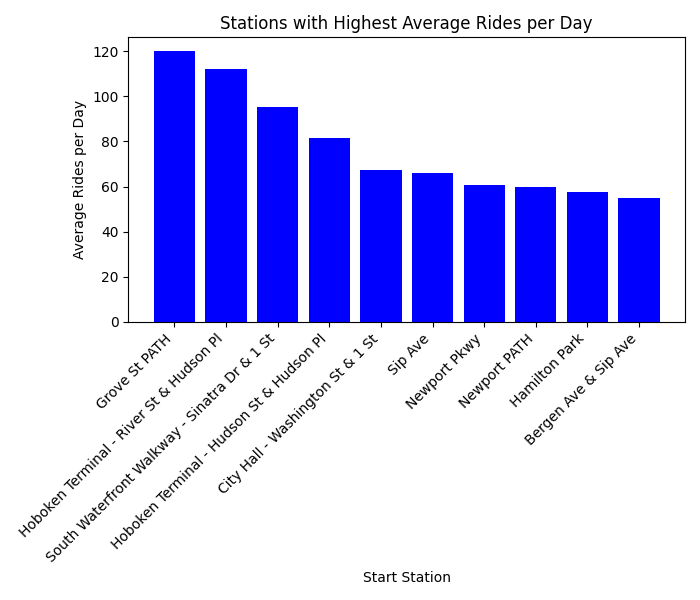

In [21]:
#Convert the `started_at` timestamp to a date and create a new column
df_3 = df_nofil.withColumn('date', to_date('started_at'))

# Group the DataFrame by start station and date and calculate the average number of rides
avg_rides_per_day_per_station = df_3.groupBy(['start_station_name', 'date']) \
                                     .agg(count('*').alias('num_rides')) \
                                     .groupBy('start_station_name') \
                                     .agg(avg('num_rides').alias('avg_rides_per_day')) \
                                     .orderBy('avg_rides_per_day', ascending=False)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = avg_rides_per_day_per_station.limit(10).toPandas()

# Plot the bar chart for stations with highest avg rides/day
plt.figure(figsize=(7,6))
plt.bar(pandas_df['start_station_name'], pandas_df['avg_rides_per_day'], color='blue')
plt.xlabel('Start Station')
plt.ylabel('Average Rides per Day')
plt.title('Stations with Highest Average Rides per Day')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
%matplot plt


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

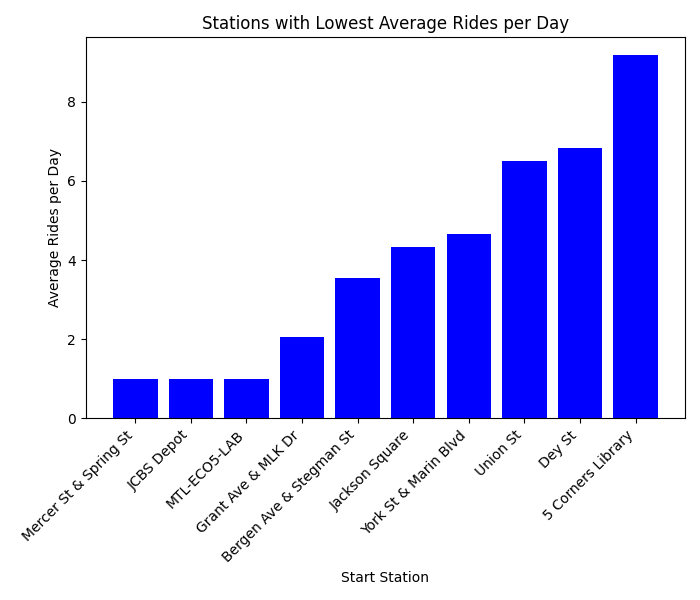

In [22]:
# Group the DataFrame by start station and date and calculate the average number of rides
avg_rides_per_day_per_station = df_3.groupBy(['start_station_name', 'date']) \
                                     .agg(count('*').alias('num_rides')) \
                                     .groupBy('start_station_name') \
                                     .agg(avg('num_rides').alias('avg_rides_per_day')) \
                                     .orderBy('avg_rides_per_day', ascending=True)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = avg_rides_per_day_per_station.limit(10).toPandas()

# Plot the bar chart for stations with lowest avg rides/day
plt.figure(figsize=(7,6))
plt.bar(pandas_df['start_station_name'], pandas_df['avg_rides_per_day'], color='blue')
plt.xlabel('Start Station')
plt.ylabel('Average Rides per Day')
plt.title('Stations with Lowest Average Rides per Day')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
%matplot plt


In [23]:
#creating folium map
# Create a DataFrame of start station metrics
start_station_metrics = df_nofil.groupBy('start_station_id', 'start_station_name') \
                          .agg(count('ride_id').alias('total_rides'), \
                               avg('start_lat').alias('start_lat'), \
                               avg('start_lng').alias('start_lng')) \
                          .orderBy(desc('total_rides'))

# Convert to Pandas DataFrame for plotting with Folium
start_station_metrics = start_station_metrics.toPandas()

# Create a Folium map centered on the city
map_center = [40.742677141, -74.051788633]
zoom_level = 13
map = folium.Map(location=map_center, zoom_start=zoom_level)

# Loop through the stations and add markers to the map
for _, row in start_station_metrics.iterrows():
    tooltip = f"{row.start_station_name} ({row.start_station_id}) - {row.total_rides} rides"
    popup = row.start_station_name
    marker_color = 'green' if row.total_rides > 10000 else 'orange' if row.total_rides > 2600 else 'red'
    folium.Marker([row.start_lat, row.start_lng], tooltip=tooltip, popup=popup,
                  icon=folium.Icon(color=marker_color, icon='cloud')).add_to(map)

    # Add marker to map
    folium.Marker([row.start_lat, row.start_lng], tooltip=tooltip, icon=folium.Icon(color=marker_color)).add_to(map)


# Upload the HTML file to S3 Bucket
s3 = boto3.client("s3")
bucket_name = "msbx5420-spr23"
file_name = "heatmap.html"
s3.put_object(Bucket=bucket_name, Key="citibike/" + file_name, Body="")
print('File Created Successfully')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

File Created Successfully

### 3. Identify the busiest times of day when bikeshare was most used, as well as the busiest day of the week

In [24]:
# Check the dimensions of the data
print("Number of rows:",df_nofil.count())
print("Number of columns:",len(df_nofil.columns))
df_nofil.printSchema()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows: 919107
Number of columns: 14
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- trip_duration: double (nullable = true)

In [25]:
c1 = '#bcbd22'
c2 = '#17becf'
c3 = '#7c7c16'
c4 = '#0f7f8a'
c5 = '#dadb37'
c6 = '#31d7e8'
line1 = '--'
line2 = '-.'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Busiest day of the week

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

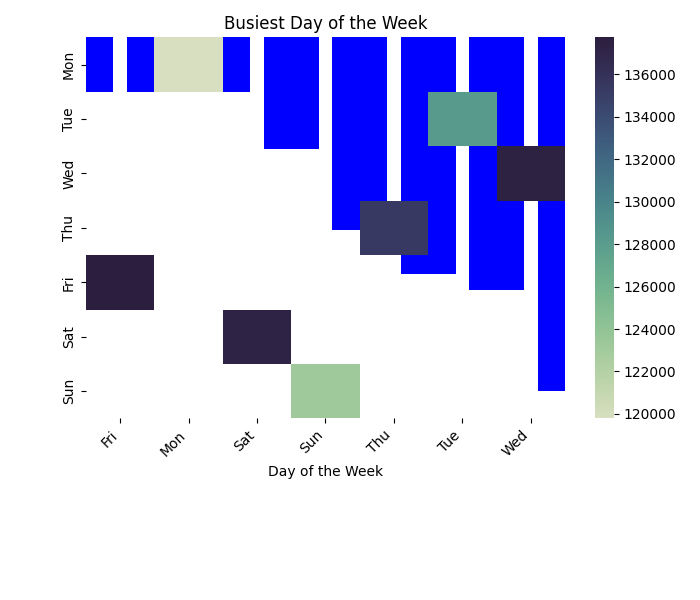

In [26]:
#Most busiest day - General

busiest_day = df_nofil.select('ride_id', date_format('started_at', 'E').alias('day_of_week'))
busiest_day.show()
busiest_day.groupBy('day_of_week').count().sort(desc('count')).show()
#Most busiest/popular day = Friday
#Least busiest/popular day = Monday

#Busiest day of the week visualization
# create a list of days of the week starting from Monday
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# group the data by day of the week and count the number of rides
busiest_day = df_nofil.groupBy(date_format('started_at', 'E').alias('day_of_week')).count().orderBy(['day_of_week'], ascending=[True])

# create a new column with the index of the day of the week
busiest_day = busiest_day.withColumn('day_of_week_index', lit(0))
for i in range(len(days_of_week)):
    busiest_day = busiest_day.withColumn('day_of_week_index', when(col('day_of_week') == days_of_week[i], i).otherwise(col('day_of_week_index')))

busiest_day.show()
# convert to pandas dataframe
busiest_day_pd = busiest_day.toPandas()

# create a pivot table
heatmap_data = busiest_day_pd.pivot(index='day_of_week_index', columns='day_of_week', values='count')

# create heatmap
sns.heatmap(heatmap_data, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), cbar=True)


# set axis labels and title
plt.title("Busiest Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("")

# set yticklabels to the actual days of the week
plt.yticks(np.arange(len(days_of_week))+0.5, days_of_week)

plt.show()
%matplot plt

### Busiest Day of the Week - Member/Non-member

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

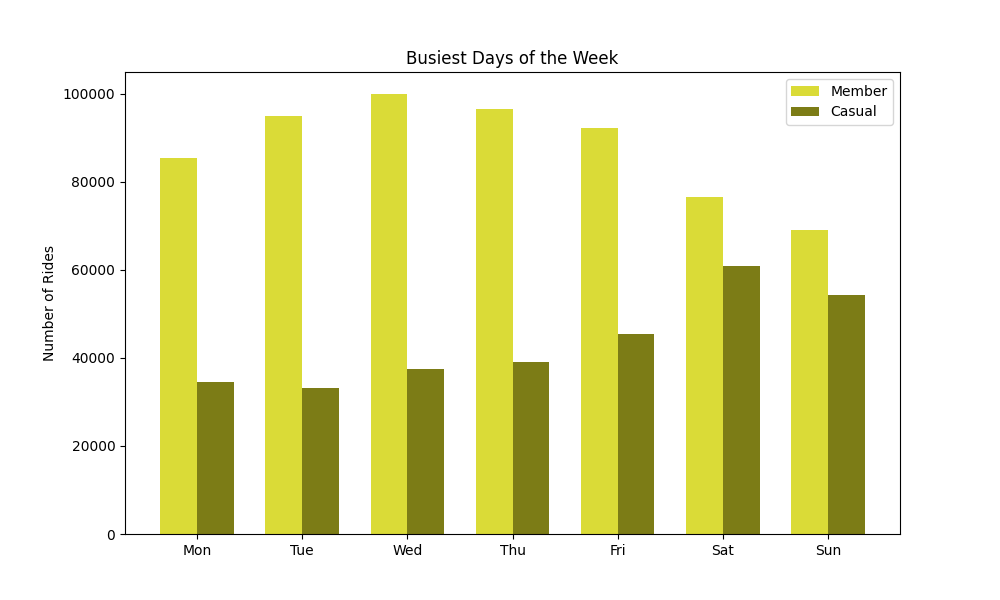

In [27]:
#Most Busiest Days - Based on Membership
busiest_day_2 = df_nofil.select('ride_id', date_format('started_at', 'E').alias('day_of_week'), 'member_casual').groupBy('day_of_week','member_casual').count()
busiest_day_2.show()

#Busiest day for members = Wednesday
busiest_day_2.filter(busiest_day_2.member_casual == "member").sort(desc('count')).show()

#Busiest day for non-members = Saturday
busiest_day_2.filter(busiest_day_2.member_casual == "casual").sort(desc('count')).show()


# Visualization

# filter busiest days for members
busiest_members = busiest_day_2.filter(busiest_day_2.member_casual == "member").sort('day_of_week')

# filter busiest days for non-members
busiest_nonmembers = busiest_day_2.filter(busiest_day_2.member_casual == "casual").sort('day_of_week')

# convert to Pandas dataframe
members_df = busiest_members.toPandas()
nonmembers_df = busiest_nonmembers.toPandas()

# create a list of days of the week in order
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# create a new column to store the order of the days
members_df['order'] = members_df['day_of_week'].apply(lambda x: days.index(x))
nonmembers_df['order'] = nonmembers_df['day_of_week'].apply(lambda x: days.index(x))

# sort the dataframes by the order column
members_df = members_df.sort_values(by='order')
nonmembers_df = nonmembers_df.sort_values(by='order')

# create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35

member_pos = np.arange(len(members_df))
nonmember_pos = [x + bar_width for x in member_pos]

ax.bar(member_pos, members_df['count'], width=bar_width, color = c5, label='Member')
ax.bar(nonmember_pos, nonmembers_df['count'], width=bar_width, color = c3, label='Casual')
ax.set_xticks(member_pos + bar_width / 2)
ax.set_xticklabels(members_df['day_of_week'])
ax.set_ylabel('Number of Rides')
ax.set_title('Busiest Days of the Week')
ax.legend()
plt.show()
%matplot plt


### Busiest time of the day to start a ride

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

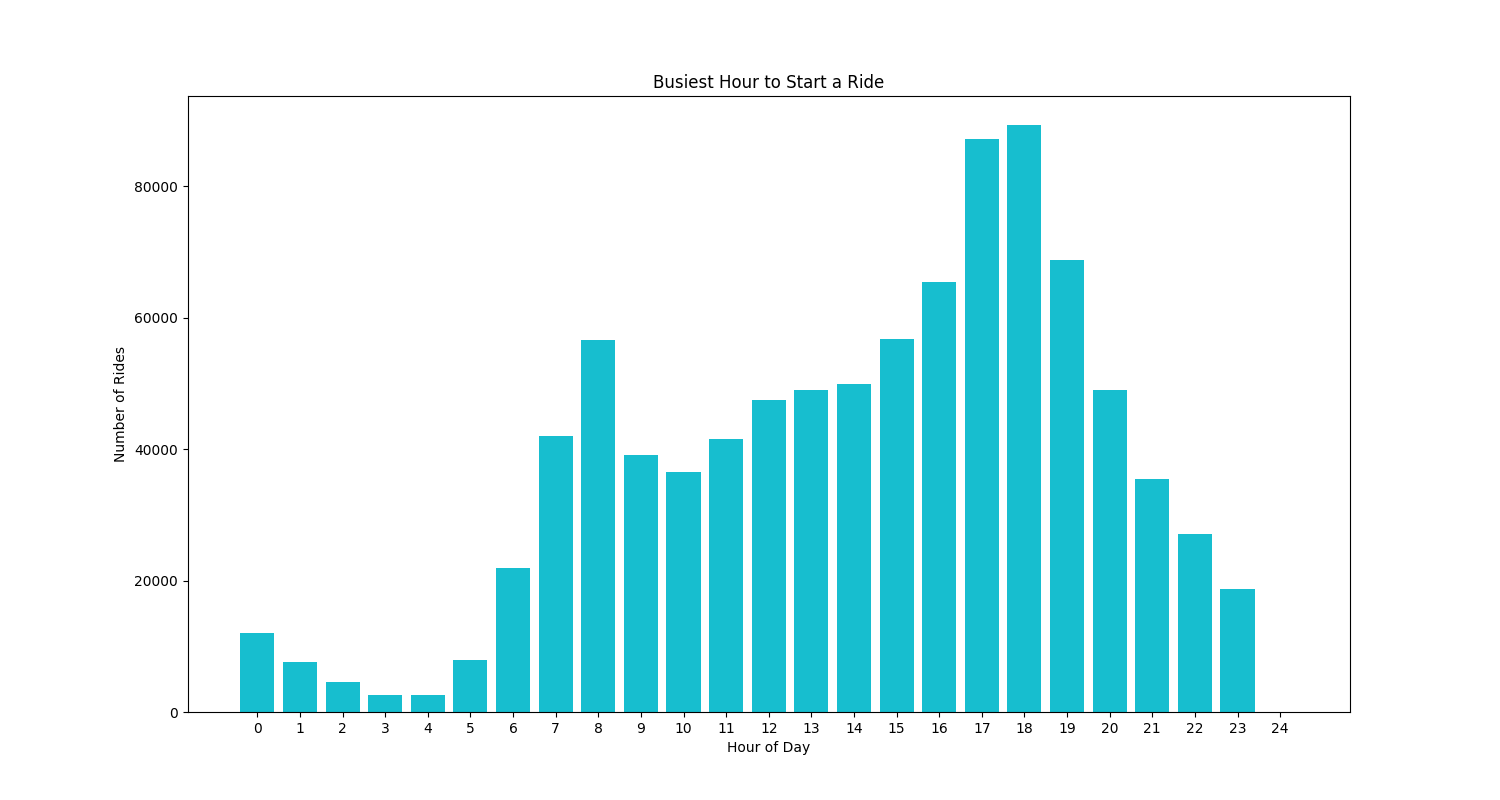

In [28]:
#Most busiest hour of the day to start a ride - General
busiest_time = df_nofil.select('ride_id', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('hour_of_day').count().orderBy('count', ascending=False)

busiest_time.show(1)
#Busiest hour of the day is 1800 to 1900 hours i.e. 6:00pm to 7:00pm  

# bar chart visualization

# create a pandas dataframe from the pyspark dataframe
busiest_time_pd = busiest_time.toPandas()

# add rows for 0 and 24 hours with count = 0
busiest_time_pd.loc[-1] = [0,0] 
busiest_time_pd.loc[24] = [24,0]
busiest_time_pd = busiest_time_pd.sort_values(by=['hour_of_day'])

# create the bar chart
plt.figure(figsize=(15,8))

# plot the bar chart
plt.bar(busiest_time_pd['hour_of_day'], busiest_time_pd['count'], color = c2)
plt.title('Busiest Hour to Start a Ride')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 25))
plt.ylabel('Number of Rides')
plt.show()
%matplot plt



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

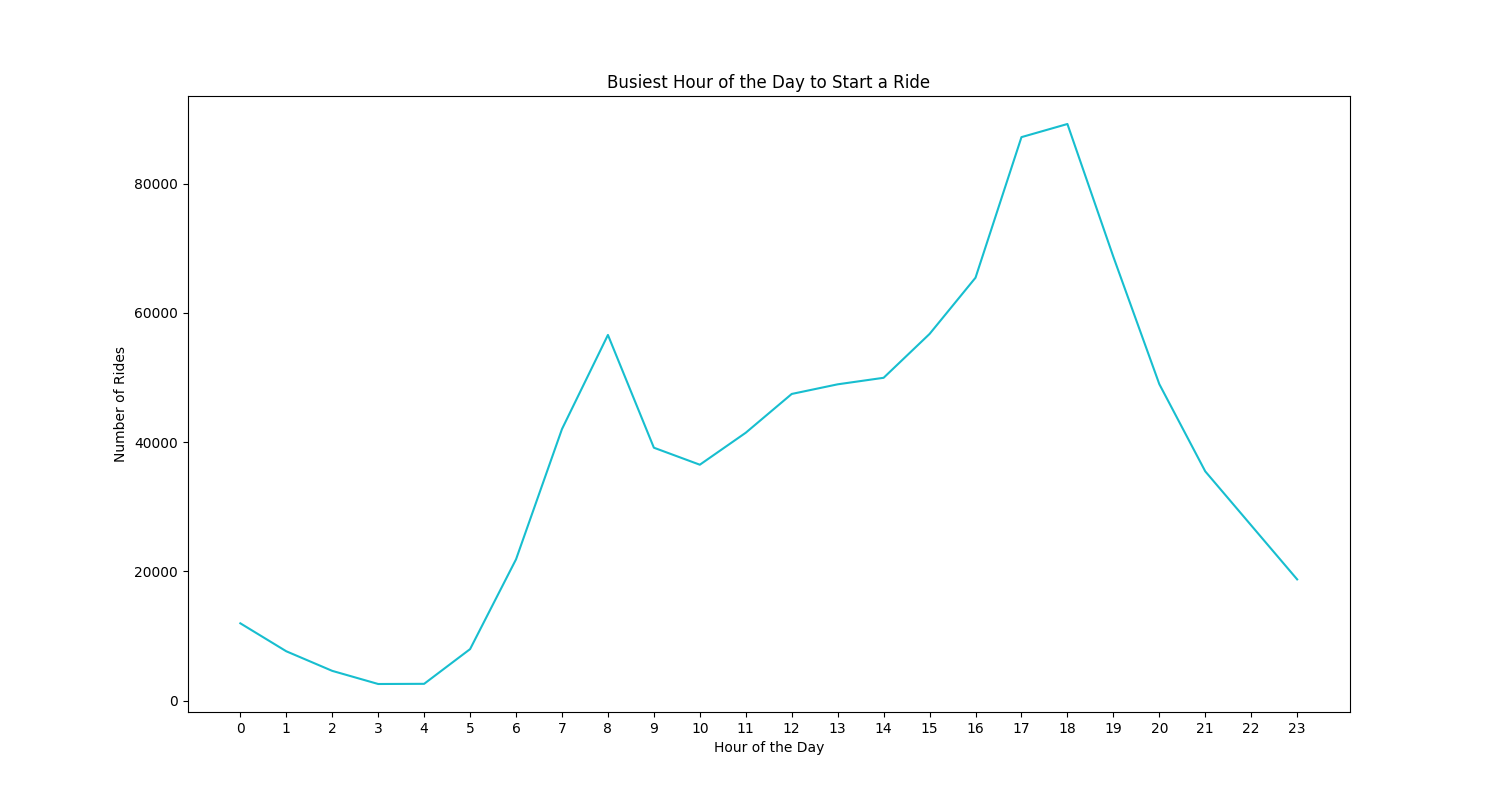

In [29]:
#line graph visualization

# Get the data
busiest_time = df_nofil.select('ride_id', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('hour_of_day').count().orderBy('hour_of_day')

# Convert the data to a list for plotting
x = busiest_time.select('hour_of_day').rdd.flatMap(lambda x: x).collect()
y = busiest_time.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(15,8))

# Create a line plot
plt.plot(x, y, color = c2)

# Set the plot title and axis labels
plt.title('Busiest Hour of the Day to Start a Ride')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')

# Set the x-axis ticks to show all 24 hours
plt.xticks(np.arange(0, 24, 1))

# Display the plot
plt.show()
%matplot plt

### Busiest time of the day to start a ride - member/non-member

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

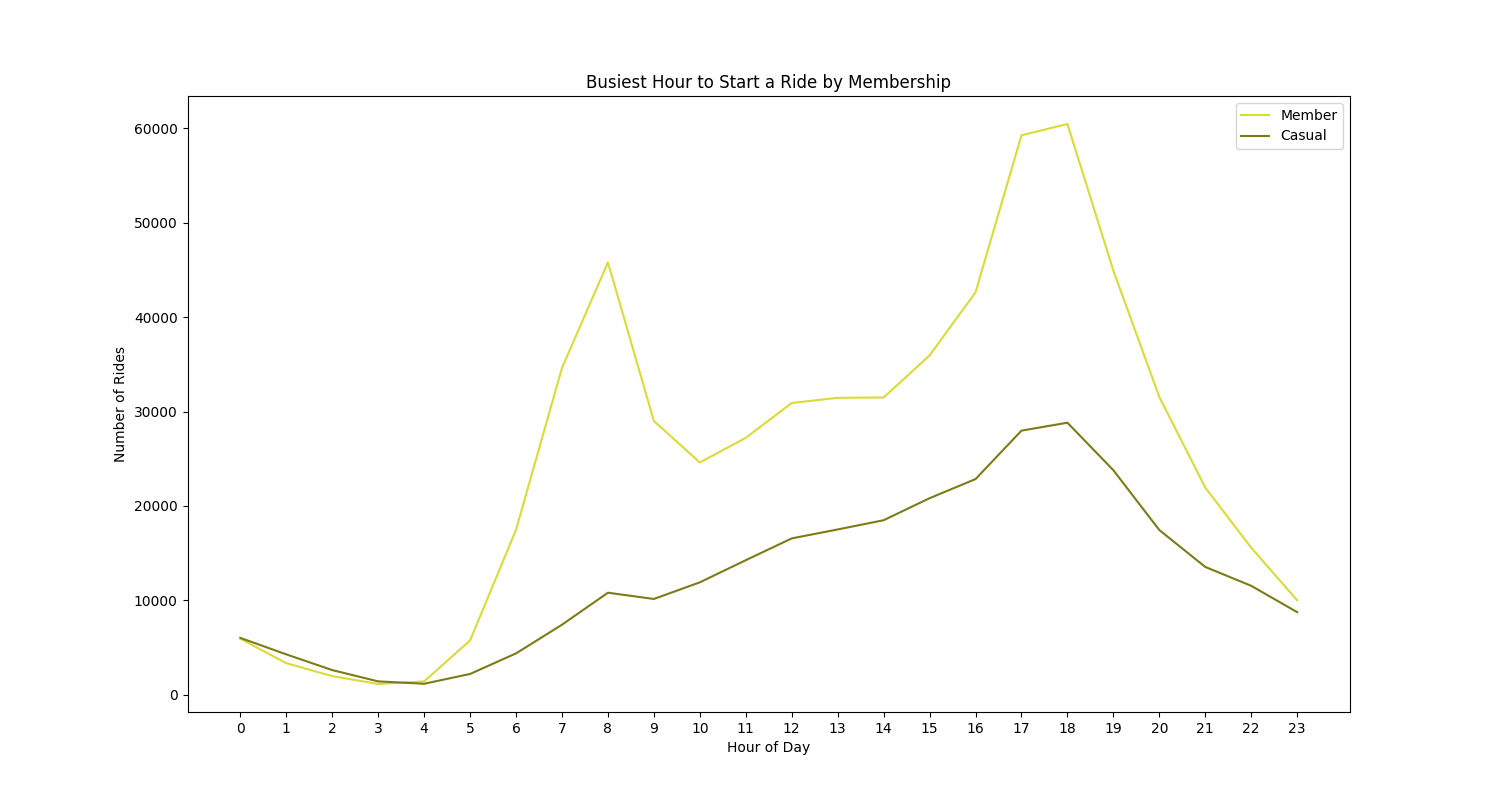

In [30]:
#Most busiest time of the day to start a ride- Based on membership
busiest_time_2 = df_nofil.select('member_casual', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('member_casual', 'hour_of_day').count().orderBy('count', ascending=False)

busiest_time_2.show()

#Busiest hour of the day for members is 6:00pm
busiest_time_2.filter(busiest_time_2.member_casual == "member").sort(desc('count')).show(1)

#Busiest hour of the day for non-members also 6:00pm
busiest_time_2.filter(busiest_time_2.member_casual == "casual").sort(desc('count')).show(1)


#visualization

# Filter data for members and casual riders
members = busiest_time_2.filter(busiest_time_2.member_casual == 'member')
casual = busiest_time_2.filter(busiest_time_2.member_casual == 'casual')

# Create arrays for x-axis (hours)
hours = np.arange(0, 24)

# Create arrays for y-axis (counts)
members_count = np.zeros(24)
for row in members.collect():
    members_count[row['hour_of_day']] = row['count']

casual_count = np.zeros(24)
for row in casual.collect():
    casual_count[row['hour_of_day']] = row['count']

# create the chart
plt.figure(figsize=(15,8))

# Plot the line chart
plt.plot(hours, members_count, color = c5, label = 'Member')
plt.plot(hours, casual_count, color = c3, label = 'Casual')

# Set chart title, x and y labels, and legend
plt.title('Busiest Hour to Start a Ride by Membership')
plt.xlabel('Hour of Day')
plt.xticks(np.arange(0, 24))
plt.ylabel('Number of Rides')
plt.legend()

plt.show()
%matplot plt

### Busiest hour of the day (most active rides)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

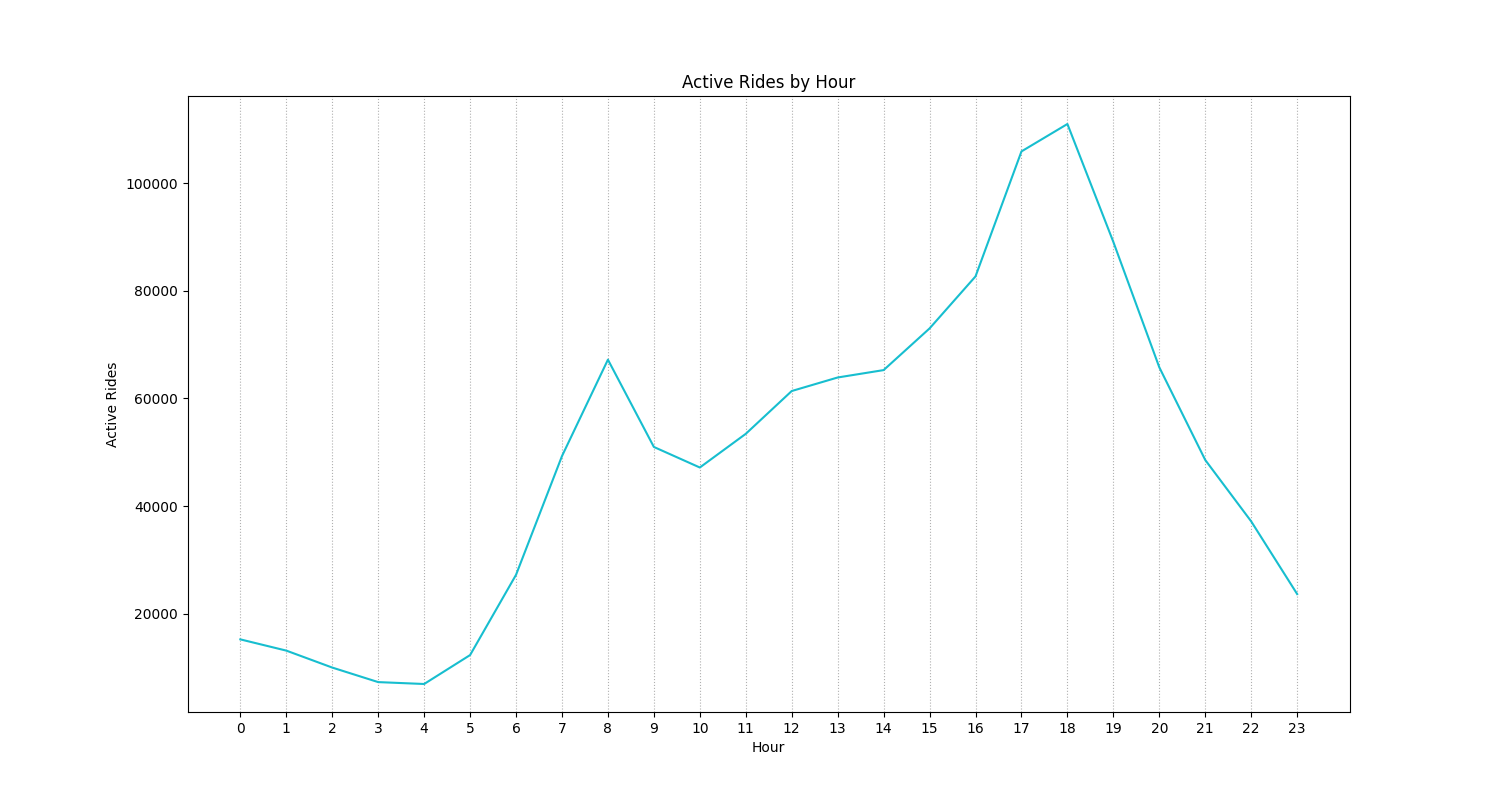

In [31]:
# Calculate the active ride time of the day
busiest_hour = df_nofil.select('ride_id', 'started_at', 'ended_at') \
                .withColumn('start_hour', hour('started_at')) \
                .withColumn('end_hour', hour('ended_at'))
busiest_hour = busiest_hour.withColumn('active', array(*[sequence(col('start_hour'), col('end_hour'))]))
busiest_hour = busiest_hour.select('ride_id', 'start_hour', 'end_hour', explode('active').alias('active'))
busiest_hour.show(5)

active_dict = {}
for row in busiest_hour.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict:
            active_dict[item] = 1
        else:
            active_dict[item] += 1
            
active_dict

#Convert dictionary to pandas dataframe
busiest_hour_df = pd.DataFrame(list(active_dict.items()), columns = ['hour', 'active rides'])
busiest_hour_df = busiest_hour_df.sort_values(by = 'hour')

print(busiest_hour_df)


#visualization

plt.figure(figsize=(15,8))
plt.plot(busiest_hour_df['hour'], busiest_hour_df['active rides'], color = c2)
plt.title('Active Rides by Hour')
plt.xlabel('Hour')
plt.xticks(busiest_hour_df['hour'])
plt.grid(axis = 'x', linestyle = ':')
plt.ylabel('Active Rides')
plt.show()
%matplot plt

### Busiest hour of the day (most active rides) - member/non-member

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

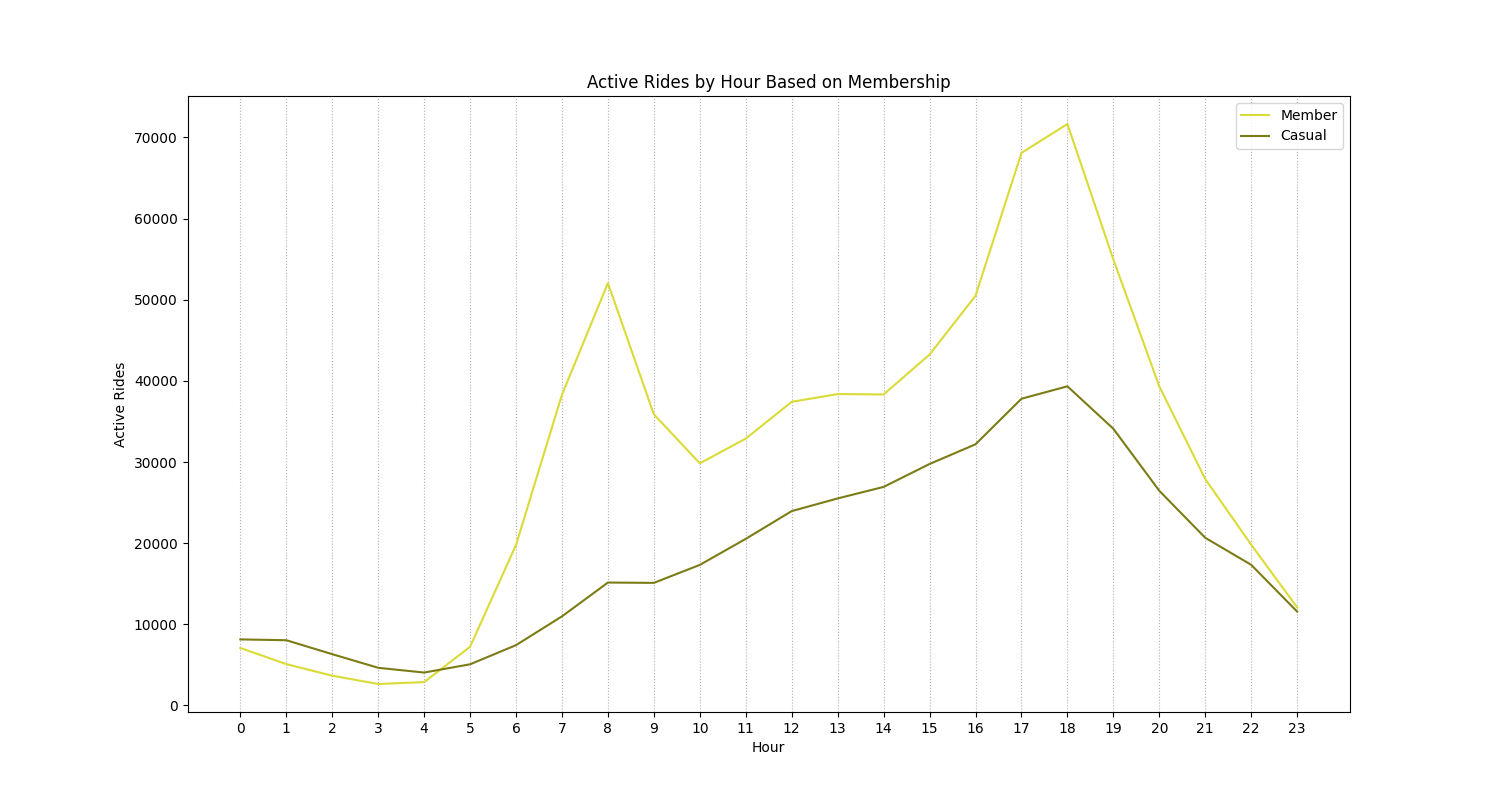

In [32]:
# Calculate the active ride time of the day
busiest_hour_2 = df_nofil.select('ride_id', 'started_at', 'ended_at', 'member_casual') \
                    .withColumn('start_hour', hour('started_at')) \
                    .withColumn('end_hour', hour('ended_at'))
busiest_hour_2 = busiest_hour_2.withColumn('active', array(*[sequence(col('start_hour'), col('end_hour'))]))
busiest_hour_2 = busiest_hour_2.select('ride_id', 'start_hour', 'end_hour', explode('active').alias('active'), 'member_casual')
busiest_hour_2.show(5)

# Filtering by members and non-members
busiest_hour_member = busiest_hour_2.filter(busiest_hour_2['member_casual'] == 'member')
busiest_hour_nonmember = busiest_hour_2.filter(busiest_hour_2['member_casual'] == 'casual')

active_dict_member = {}
for row in busiest_hour_member.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict_member:
            active_dict_member[item] = 1
        else:
            active_dict_member[item] += 1
            
active_dict_member

active_dict_nonmember = {}
for row in busiest_hour_nonmember.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict_nonmember:
            active_dict_nonmember[item] = 1
        else:
            active_dict_nonmember[item] += 1
            
active_dict_nonmember


#Convert dictionary to pandas dataframe
busiest_hour_memberdf = pd.DataFrame(list(active_dict_member.items()), columns = ['hour', 'active rides'])
busiest_hour_memberdf = busiest_hour_memberdf.sort_values(by = 'hour')

print(busiest_hour_memberdf)

#Convert dictionary to pandas dataframe
busiest_hour_nonmemberdf = pd.DataFrame(list(active_dict_nonmember.items()), columns = ['hour', 'active rides'])
busiest_hour_nonmemberdf = busiest_hour_nonmemberdf.sort_values(by = 'hour')

print(busiest_hour_nonmemberdf)


#visualization

plt.figure(figsize=(15,8))

plt.plot(busiest_hour_memberdf['hour'], busiest_hour_memberdf['active rides'], color = c5, label = 'Member')
plt.plot(busiest_hour_nonmemberdf['hour'], busiest_hour_nonmemberdf['active rides'], color = c3, label = 'Casual')

plt.title('Active Rides by Hour Based on Membership')
plt.xlabel('Hour')
plt.xticks(busiest_hour_memberdf['hour'])
plt.grid(axis = 'x', linestyle = ':')
plt.ylabel('Active Rides')
plt.legend()
plt.show()
%matplot plt


### 4. Deduce a variation in bikeshare trends pre-COVID (before 2020) and post COVID (2020-2021)

#### Loading in data 

In [33]:
# data with trips under one minute and over 30 minutes filtered out
df_pre = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/covid_19_clean_data.csv")
df_post = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/covid_22_clean_data.csv")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Data to parquet

In [34]:
#### Read the CSV file into a DataFrame
df_transform2 = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/covid_19_clean_data.csv")

#### Write the DataFrame to a Parquet file
df_transform2.write.parquet("s3://msbx5420-spr23/citibike/covid_19_clean_data_pq.parquet")

#### Upload Parquet File
df_pre = spark.read.format("parquet").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/covid_19_clean_data_pq.parquet")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
path s3://msbx5420-spr23/citibike/covid_19_clean_data_pq.parquet already exists.
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/readwriter.py", line 1140, in parquet
    self._jwrite.parquet(path)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/utils.py", line 196, in deco
    raise converted from None
pyspark.sql.utils.AnalysisException: path s3://msbx5420-spr23/citibike/covid_19_clean_data_pq.parquet already exists.



In [35]:
#### Read the CSV file into a DataFrame
df_transform3 = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/covid_22_clean_data.csv")

#### Write the DataFrame to a Parquet file
df_transform3.write.parquet("s3://msbx5420-spr23/citibike/covid_22_clean_data_pq.parquet")

#### Upload Parquet File
df_post = spark.read.format("parquet").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/covid_22_clean_data_pq.parquet")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
path s3://msbx5420-spr23/citibike/covid_22_clean_data_pq.parquet already exists.
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/readwriter.py", line 1140, in parquet
    self._jwrite.parquet(path)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/utils.py", line 196, in deco
    raise converted from None
pyspark.sql.utils.AnalysisException: path s3://msbx5420-spr23/citibike/covid_22_clean_data_pq.parquet already exists.



In [36]:
# Check the dimensions of the data
print("---------Pre-Covid Data---------")
print("Number of rows:",df_pre.count())
print("Number of columns:",len(df_pre.columns))
print('________Schema____________')

# print the data frame's schema
df_pre.printSchema()

print("---------Post-Covid Data---------")
print("Number of rows:",df_post.count())
print("Number of columns:",len(df_post.columns))
print('________Schema____________')

# print the data frame's schema
df_post.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
Number of rows: 40975
Number of columns: 13
________Schema____________
root
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- index: long (nullable = true)
 |-- trip_duration: double (nullable = true)

---------Post-Covid Data---------
Number of rows: 93620
Number of columns: 13
________Schema____________
root
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: stri

#### Membership trends (pre- and post-Covid)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

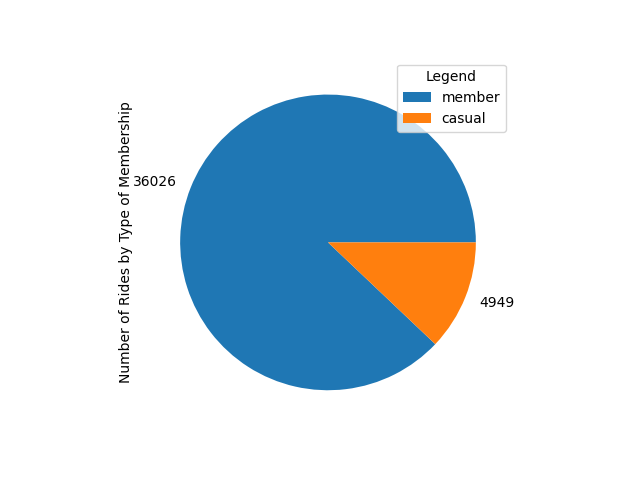

In [37]:
def pieplot(df, col, yname=None):

    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = df.groupBy(col).count().orderBy('count(1)', ascending=False)
    
    # convert to pandas  
    pd_df = classes.toPandas()
    
    # Making plot 
    pd_df.plot(kind='pie', x=col, y='count(1)', \
           labels=pd_df[col[1]], legend=True)
    plt.legend(title='Legend', labels=['member','casual'], loc='upper right')
    plt.ylabel('Number of Rides by Type of Membership')
    plt.show()
    

print("---------Pre-Covid Data---------")
user_type_pre = df_pre.groupBy('member_casual').agg(count('*')).alias('user_count')
user_type_pre.show()
pieplot(user_type_pre, ['member_casual','count(1)'])
%matplot plt




FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

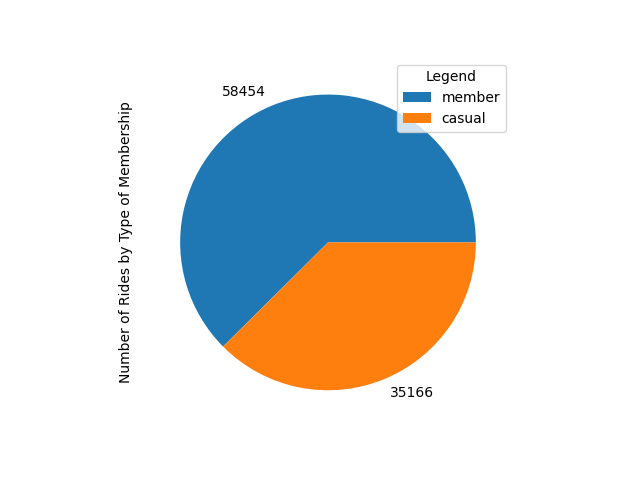

In [38]:
print("---------Post-Covid Data---------")
user_type_post = df_post.groupBy('member_casual').agg(count('*')).alias('user_count')
user_type_post.show()
pieplot(user_type_post, ['member_casual','count(1)'])
%matplot plt

#### Popular routes (pre- and post-Covid)

In [39]:
# route counts dataframe

#Pre-Covid data
route_counts_pre = df_pre.groupby(['start_station_name', 'end_station_name','start_lat','start_lng','end_lat','end_lng']).agg(count('index').alias('num_rides')).filter(col("start_station_name") != col("end_station_name")).sort(desc('num_rides'))
# Post-Covid data
route_counts_post = df_post.groupby(['start_station_name', 'end_station_name','start_lat','start_lng','end_lat','end_lng']).agg(count('index').alias('num_rides')).filter(col("start_station_name") != col("end_station_name")).sort(desc('num_rides'))

# trip duration dataframe 
#Pre-Covid data
trip_dur_station_pre = df_pre.groupBy('start_station_name','end_station_name').sum('trip_duration').sort(desc('sum(trip_duration)'))
trip_dur_station_pre = trip_dur_station_pre.withColumnRenamed('sum(trip_duration)', 'trip_dur')
# Post-Covid data
trip_dur_station_post = df_post.groupBy('start_station_name','end_station_name').sum('trip_duration').sort(desc('sum(trip_duration)'))
trip_dur_station_post = trip_dur_station_post.withColumnRenamed('sum(trip_duration)', 'trip_dur')

# join the two 
print("---------Pre-Covid Data---------")
trip_dur_all_pre = trip_dur_station_pre.join(route_counts_pre, on = ['start_station_name','end_station_name'])
trip_dur_all_pre=trip_dur_all_pre.drop('start_lat','start_lng','end_lat','end_lng')
trip_dur_all_pre = trip_dur_all_pre.sort(desc('num_rides'))
trip_dur_all_pre.select('start_station_name','end_station_name','trip_dur','num_rides').show()

print('Minutes on bikes')
trip_dur_all_pre.select(sum(trip_dur_all_pre.trip_dur)/sum(trip_dur_all_pre.num_rides)).show()

print("---------Post-Covid Data---------")
trip_dur_all_post = trip_dur_station_post.join(route_counts_post, on = ['start_station_name','end_station_name'])
trip_dur_all_post=trip_dur_all_post.drop('start_lat','start_lng','end_lat','end_lng')
trip_dur_all_post = trip_dur_all_post.sort(desc('num_rides'))
trip_dur_all_post.select('start_station_name','end_station_name','trip_dur','num_rides').show()

print('Minutes on bikes')
trip_dur_all_post.select(sum(trip_dur_all_post.trip_dur)/sum(trip_dur_all_post.num_rides)).show()



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
+------------------+----------------+--------+---------+
|start_station_name|end_station_name|trip_dur|num_rides|
+------------------+----------------+--------+---------+
|     Hamilton Park|   Grove St PATH|  5030.0|      960|
|     Grove St PATH|   Hamilton Park|  3271.0|      609|
|   Brunswick & 6th|   Grove St PATH|  3218.0|      569|
|  Marin Light Rail|   Grove St PATH|  2425.0|      543|
|     Grove St PATH|Marin Light Rail|  2412.0|      515|
|   Jersey & 6th St|   Grove St PATH|  1802.0|      441|
|  Monmouth and 6th|   Grove St PATH|  2256.0|      439|
|      Brunswick St|   Grove St PATH|  1980.0|      430|
|       Dixon Mills|   Grove St PATH|  1355.0|      428|
|   McGinley Square|         Sip Ave|  1680.0|      387|
|     Grove St PATH|     Dixon Mills|  1315.0|      350|
|     Grove St PATH| Brunswick & 6th|  2002.0|      346|
|      Newport PATH|      Harborside|  2060.0|      340|
|     Grove St PATH|    Brunswick St|  1574.0|      316

### Usage Analysis (Pre- and Post-Covid)

In [40]:
# data with trips over one minute
pre_nf = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/m_covid_19_clean.csv")
post_nf = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/m_covid_22_clean.csv")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### data to parquet

In [41]:
#### Read the CSV file into a DataFrame
df_transform4 = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/m_covid_19_clean.csv")

#### Write the DataFrame to a Parquet file
df_transform4.write.parquet("s3://msbx5420-spr23/citibike/m_covid_19_clean_pq.parquet")

#### Upload Parquet File
pre_nf = spark.read.format("parquet").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/m_covid_19_clean_pq.parquet")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
path s3://msbx5420-spr23/citibike/m_covid_19_clean_pq.parquet already exists.
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/readwriter.py", line 1140, in parquet
    self._jwrite.parquet(path)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/utils.py", line 196, in deco
    raise converted from None
pyspark.sql.utils.AnalysisException: path s3://msbx5420-spr23/citibike/m_covid_19_clean_pq.parquet already exists.



In [42]:
#### Read the CSV file into a DataFrame
df_transform5 = spark.read.format("csv").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/m_covid_22_clean.csv")

#### Write the DataFrame to a Parquet file
df_transform5.write.parquet("s3://msbx5420-spr23/citibike/m_covid_22_clean_pq.parquet")

#### Upload Parquet File
post_nf = spark.read.format("parquet").option("header",True).option("inferSchema",True).load("s3://msbx5420-spr23/citibike/m_covid_22_clean_pq.parquet")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
path s3://msbx5420-spr23/citibike/m_covid_22_clean_pq.parquet already exists.
Traceback (most recent call last):
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/readwriter.py", line 1140, in parquet
    self._jwrite.parquet(path)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/mnt/yarn/usercache/livy/appcache/application_1681238170162_0382/container_1681238170162_0382_01_000001/pyspark.zip/pyspark/sql/utils.py", line 196, in deco
    raise converted from None
pyspark.sql.utils.AnalysisException: path s3://msbx5420-spr23/citibike/m_covid_22_clean_pq.parquet already exists.



In [43]:
# Check the dimensions of the data
print("---------Pre-Covid Data---------")
print("Number of rows:",pre_nf.count())
print("Number of columns:",len(pre_nf.columns))
print('________Schema____________')

# print the data frame's schema
pre_nf.printSchema()

print("---------Post-Covid Data---------")
print("Number of rows:",post_nf.count())
print("Number of columns:",len(post_nf.columns))
print('________Schema____________')

# print the data frame's schema
post_nf.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
Number of rows: 43430
Number of columns: 13
________Schema____________
root
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- index: long (nullable = true)
 |-- trip_duration: double (nullable = true)

---------Post-Covid Data---------
Number of rows: 104745
Number of columns: 13
________Schema____________
root
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: str

#### Average rides per day per station

In [44]:
print("---------Pre-Covid Data---------")
# Group the data by start station and calculate total rides
start_station_metrics = pre_nf.groupBy('start_station_id', 'start_station_name') \
                          .agg(count('start_station_id').alias('total_rides')) \
                          .orderBy(desc('total_rides'))

# Group the data by end station and calculate total rides
end_station_metrics = pre_nf.groupBy('end_station_id', 'end_station_name') \
                        .agg(count('end_station_id').alias('total_rides')) \
                        .orderBy(desc('total_rides'))

# Show the resulting DataFrames
start_station_metrics.show(5)
end_station_metrics.show(5)

# Convert the `started_at` timestamp to a date and create a new column
df_2 = pre_nf.withColumn('date', to_date('started_at'))

# Calculate the total number of rides and the number of days in the dataset
total_rides = df_2.count()
total_days = df_2.select('date').distinct().count()

# Calculate the average number of rides per day
avg_rides_per_day = total_rides / total_days

# Print the result
print(f"Total number of rides: {total_rides}")
print(f"Total number of days: {total_days}")
print(f"Average number of rides per day: {avg_rides_per_day}")

# Group the data by start station name
grouped_df = df_2.groupBy('start_station_name')

# Calculate the total number of rides and the number of days for each start station
rides_per_station = grouped_df.agg(count('*').alias('num_rides'))

# Calculate the total number of start stations
total_stations = rides_per_station.select('start_station_name').distinct().count()

# Calculate the number of days for each start station
days_per_station = df_2.groupBy('start_station_name', 'date').agg(count('*').alias('num_days')) \
                     .groupBy('start_station_name').agg(count('*').alias('num_days'))

# Calculate the average number of rides per day for each start station
avg_rides_per_day_per_station = rides_per_station.join(days_per_station, 'start_station_name') \
                                       .withColumn('avg_rides_per_day', rides_per_station['num_rides'] / days_per_station['num_days']) \
                                       .orderBy('avg_rides_per_day', ascending=False)

# Print the results
print(f"Total number of rides: {total_rides}")
print(f"Total number of days: {total_days}")
print(f"Total number of stations: {total_stations}")
avg_rides_per_day_per_station.show(5)


# Visualization for stations with highest avg rides/day
# Convert the `started_at` timestamp to a date and create a new column
df_3 = pre_nf.withColumn('date', to_date('started_at'))

# Group the DataFrame by start station and date and calculate the average number of rides
avg_rides_per_day_per_station = df_3.groupBy(['start_station_name', 'date']) \
                                     .agg(count('*').alias('num_rides')) \
                                     .groupBy('start_station_name') \
                                     .agg(avg('num_rides').alias('avg_rides_per_day')) \
                                     .orderBy('avg_rides_per_day', ascending=False)



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
+----------------+------------------+-----------+
|start_station_id|start_station_name|total_rides|
+----------------+------------------+-----------+
|            3186|     Grove St PATH|       4798|
|            3203|     Hamilton Park|       2670|
|            3639|        Harborside|       2014|
|            3195|           Sip Ave|       2003|
|            3202|      Newport PATH|       1740|
+----------------+------------------+-----------+
only showing top 5 rows

+--------------+----------------+-----------+
|end_station_id|end_station_name|total_rides|
+--------------+----------------+-----------+
|          3186|   Grove St PATH|       6250|
|          3203|   Hamilton Park|       2433|
|          3639|      Harborside|       2014|
|          3202|    Newport PATH|       1940|
|          3195|         Sip Ave|       1933|
+--------------+----------------+-----------+
only showing top 5 rows

Total number of rides: 43430
Total number of days: 31

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

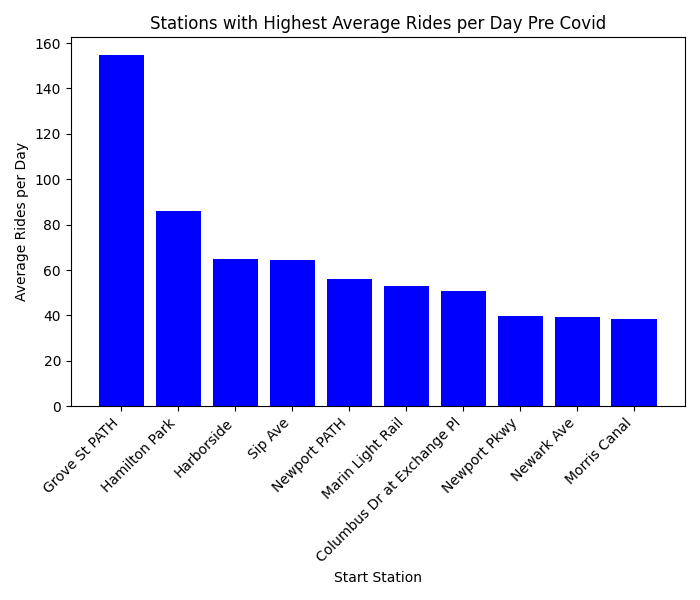

In [45]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = avg_rides_per_day_per_station.limit(10).toPandas()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(7, 6))
plt.bar(pandas_df['start_station_name'], pandas_df['avg_rides_per_day'], color='blue')
plt.xlabel('Start Station')
plt.ylabel('Average Rides per Day')
plt.title('Stations with Highest Average Rides per Day Pre Covid')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
%matplot plt


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

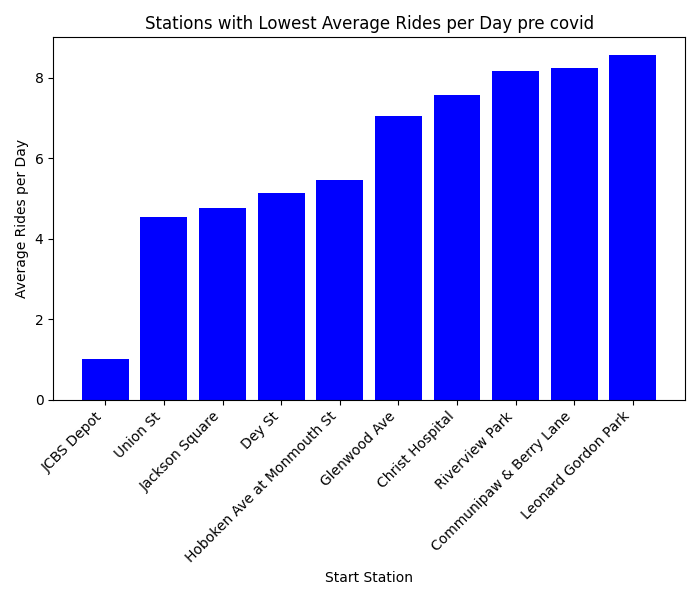

In [46]:
# Visualization for stations with lowest avg rides/day pre covid
# Group the DataFrame by start station and date and calculate the average number of rides
avg_rides_per_day_per_station = df_3.groupBy(['start_station_name', 'date']) \
                                     .agg(count('*').alias('num_rides')) \
                                     .groupBy('start_station_name') \
                                     .agg(avg('num_rides').alias('avg_rides_per_day')) \
                                     .orderBy('avg_rides_per_day', ascending=True)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = avg_rides_per_day_per_station.limit(10).toPandas()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(7, 6))
plt.bar(pandas_df['start_station_name'], pandas_df['avg_rides_per_day'], color='blue')
plt.xlabel('Start Station')
plt.ylabel('Average Rides per Day')
plt.title('Stations with Lowest Average Rides per Day pre covid')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
%matplot plt


In [47]:
# folium visualization 
# Create a DataFrame of start station metrics
start_station_metrics = pre_nf.groupBy('start_station_id', 'start_station_name') \
                          .agg(count('start_station_id').alias('total_rides'), \
                               avg('start_lat').alias('start_lat'), \
                               avg('start_lng').alias('start_lng')) \
                          .orderBy(desc('total_rides'))
# Convert to Pandas DataFrame for plotting with Folium
start_station_metrics = start_station_metrics.toPandas()

# Create a Folium map centered on the city
map_center = [40.742677141, -74.051788633]
zoom_level = 13
map = folium.Map(location=map_center, zoom_start=zoom_level)

# Loop through the stations and add markers to the map
for _, row in start_station_metrics.iterrows():
    tooltip = f"{row.start_station_name} ({row.start_station_id}) - {row.total_rides} rides"
    popup = row.start_station_name
    marker_color = 'green' if row.total_rides > 2400 else 'orange' #if row.total_rides==2400 else 'red'
        
    folium.Marker([row.start_lat, row.start_lng], tooltip=tooltip, popup=popup,
                  icon=folium.Icon(color=marker_color, icon='cloud')).add_to(map)
    # Add marker to map
    folium.Marker([row.start_lat, row.start_lng], tooltip=tooltip, icon=folium.Icon(color=marker_color)).add_to(map)

    # Upload the HTML file to S3 Bucket
s3 = boto3.client("s3")
bucket_name = "msbx5420-spr23"
file_name = "pre_covid_heatmap.html"
s3.put_object(Bucket=bucket_name, Key="citibike/" + file_name, Body="")
print('File Created Successfully')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

File Created Successfully

In [48]:
print("---------Post-Covid Data---------")
# Group the data by start station and calculate total rides
start_station_metrics = post_nf.groupBy('start_station_id', 'start_station_name') \
                          .agg(count('start_station_id').alias('total_rides')) \
                          .orderBy(desc('total_rides'))

# Group the data by end station and calculate total rides
end_station_metrics = post_nf.groupBy('end_station_id', 'end_station_name') \
                        .agg(count('end_station_id').alias('total_rides')) \
                        .orderBy(desc('total_rides'))

# Show the resulting DataFrames
start_station_metrics.show(5)
end_station_metrics.show(5)

# Convert the `started_at` timestamp to a date and create a new column
df_2 = post_nf.withColumn('date', to_date('started_at'))

# Calculate the total number of rides and the number of days in the dataset
total_rides = df_2.count()
total_days = df_2.select('date').distinct().count()

# Calculate the average number of rides per day
avg_rides_per_day = total_rides / total_days

# Print the result
print(f"Total number of rides: {total_rides}")
print(f"Total number of days: {total_days}")
print(f"Average number of rides per day: {avg_rides_per_day}")

# Group the data by start station name
grouped_df = df_2.groupBy('start_station_name')

# Calculate the total number of rides and the number of days for each start station
rides_per_station = grouped_df.agg(count('*').alias('num_rides'))

# Calculate the total number of start stations
total_stations = rides_per_station.select('start_station_name').distinct().count()

# Calculate the number of days for each start station
days_per_station = df_2.groupBy('start_station_name', 'date').agg(count('*').alias('num_days')) \
                     .groupBy('start_station_name').agg(count('*').alias('num_days'))

# Calculate the average number of rides per day for each start station
avg_rides_per_day_per_station = rides_per_station.join(days_per_station, 'start_station_name') \
                                       .withColumn('avg_rides_per_day', rides_per_station['num_rides'] / days_per_station['num_days']) \
                                       .orderBy('avg_rides_per_day', ascending=False)

# Print the results
print(f"Total number of rides: {total_rides}")
print(f"Total number of days: {total_days}")
print(f"Total number of stations: {total_stations}")
avg_rides_per_day_per_station.show()




FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Post-Covid Data---------
+----------------+--------------------+-----------+
|start_station_id|  start_station_name|total_rides|
+----------------+--------------------+-----------+
|           JC005|       Grove St PATH|       4677|
|           HB103|South Waterfront ...|       4354|
|           HB102|Hoboken Terminal ...|       3748|
|           JC008|        Newport Pkwy|       3111|
|           HB101|Hoboken Terminal ...|       3047|
+----------------+--------------------+-----------+
only showing top 5 rows

+--------------+--------------------+-----------+
|end_station_id|    end_station_name|total_rides|
+--------------+--------------------+-----------+
|         JC005|       Grove St PATH|       4835|
|         HB103|South Waterfront ...|       4433|
|         HB102|Hoboken Terminal ...|       3389|
|         HB101|Hoboken Terminal ...|       3257|
|         JC008|        Newport Pkwy|       3105|
+--------------+--------------------+-----------+
only showing top 5 rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

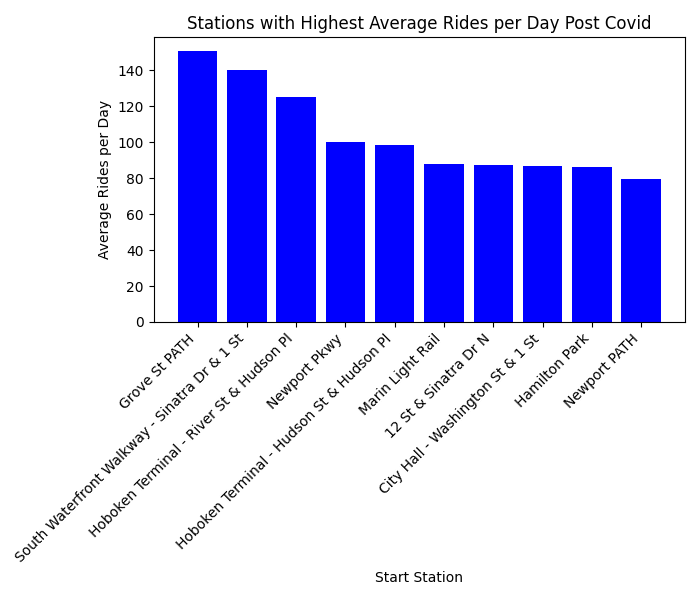

In [49]:
# Visualization for stations with highest avg rides/day post covid
# Convert the `started_at` timestamp to a date and create a new column
df_3 = post_nf.withColumn('date', to_date('started_at'))

# Group the DataFrame by start station and date and calculate the average number of rides
avg_rides_per_day_per_station = df_3.groupBy(['start_station_name', 'date']) \
                                     .agg(count('*').alias('num_rides')) \
                                     .groupBy('start_station_name') \
                                     .agg(avg('num_rides').alias('avg_rides_per_day')) \
                                     .orderBy('avg_rides_per_day', ascending=False)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = avg_rides_per_day_per_station.limit(10).toPandas()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(7, 6))
plt.bar(pandas_df['start_station_name'], pandas_df['avg_rides_per_day'], color='blue')
plt.xlabel('Start Station')
plt.ylabel('Average Rides per Day')
plt.title('Stations with Highest Average Rides per Day Post Covid')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
%matplot plt



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

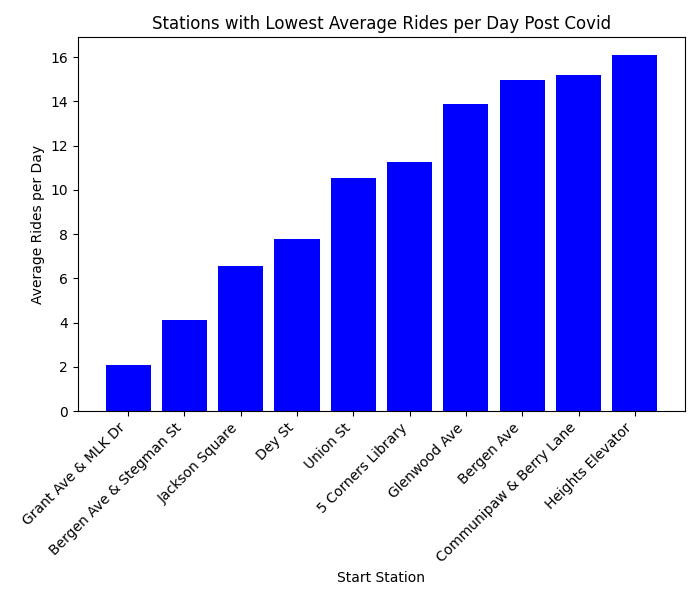

In [50]:
# Visualization for stations with lowest avg rides/day post Covid
# Group the DataFrame by start station and date and calculate the average number of rides
avg_rides_per_day_per_station = df_3.groupBy(['start_station_name', 'date']) \
                                     .agg(count('*').alias('num_rides')) \
                                     .groupBy('start_station_name') \
                                     .agg(avg('num_rides').alias('avg_rides_per_day')) \
                                     .orderBy('avg_rides_per_day', ascending=True)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = avg_rides_per_day_per_station.limit(10).toPandas()

# Plot the bar chart
plt.figure(figsize=(7,6))
plt.bar(pandas_df['start_station_name'], pandas_df['avg_rides_per_day'], color='blue')
plt.xlabel('Start Station')
plt.ylabel('Average Rides per Day')
plt.title('Stations with Lowest Average Rides per Day Post Covid')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
%matplot plt



In [51]:
# folium visualization 
# Create a DataFrame of start station metrics
start_station_metrics = post_nf.groupBy('start_station_id', 'start_station_name') \
                          .agg(count('start_station_id').alias('total_rides'), \
                               avg('start_lat').alias('start_lat'), \
                               avg('start_lng').alias('start_lng')) \
                          .orderBy(desc('total_rides'))
# Convert to Pandas DataFrame for plotting with Folium
start_station_metrics = start_station_metrics.toPandas()

# Create a Folium map centered on the city
map_center = [40.742677141, -74.051788633]
zoom_level = 13
map = folium.Map(location=map_center, zoom_start=zoom_level)

# Loop through the stations and add markers to the map
for _, row in start_station_metrics.iterrows():
    tooltip = f"{row.start_station_name} ({row.start_station_id}) - {row.total_rides} rides"
    popup = row.start_station_name
    marker_color = 'green' if row.total_rides > 2400 else 'orange' #if row.total_rides==2400 else 'red'
        
    folium.Marker([row.start_lat, row.start_lng], tooltip=tooltip, popup=popup,
                  icon=folium.Icon(color=marker_color, icon='cloud')).add_to(map)
    # Add marker to map
    folium.Marker([row.start_lat, row.start_lng], tooltip=tooltip, icon=folium.Icon(color=marker_color)).add_to(map)

# Upload the HTML file to S3 Bucket
s3 = boto3.client("s3")
bucket_name = "msbx5420-spr23"
file_name = "post_covid_heatmap.html"
s3.put_object(Bucket=bucket_name, Key="citibike/" + file_name, Body="")
print('File Created Successfully')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

File Created Successfully

### BUSIEST TIMES (PRE- AND POST-COVID) 


In [52]:
c1 = '#bcbd22'
c2 = '#17becf'
c3 = '#7c7c16'
c4 = '#0f7f8a'
c5 = '8c564b'
c6 = 'e377c2'
line1 = '--'
line2 = '-.'


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Busiest Days of the Week 

In [53]:
print("---------Pre-Covid Data---------")

#Most busiest day in 2019

busiest_day_2019 = pre_nf.select('index', date_format('started_at', 'E').alias('day_of_week'))
busiest_day_2019.show(5)
busiest_day_2019.groupBy('day_of_week').count().sort(desc('count')).show(5)
#Most busiest/popular day in 2019 = Tuesday
#Least busiest/popular day in 2019 = Sunday



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
+-----+-----------+
|index|day_of_week|
+-----+-----------+
|    0|        Mon|
|    1|        Mon|
|    2|        Mon|
|    3|        Mon|
|    4|        Mon|
+-----+-----------+
only showing top 5 rows

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|        Tue| 7958|
|        Wed| 7825|
|        Mon| 7203|
|        Fri| 6121|
|        Thu| 5314|
+-----------+-----+
only showing top 5 rows

In [54]:
print("---------Post-Covid Data---------")
#Most busiest day in 2022 - General

busiest_day_2022 = post_nf.select('index', date_format('started_at', 'E').alias('day_of_week'))
busiest_day_2022.show(5)
busiest_day_2022.groupBy('day_of_week').count().sort(desc('count')).show()
#Most busiest/popular day in 2022 = Saturday
#Least busiest/popular day in 2022 = Monday

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Post-Covid Data---------
+-----+-----------+
|index|day_of_week|
+-----+-----------+
|    0|        Thu|
|    1|        Thu|
|    2|        Sat|
|    3|        Sat|
|    4|        Thu|
+-----+-----------+
only showing top 5 rows

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|        Sat|18497|
|        Sun|16864|
|        Fri|16548|
|        Wed|13880|
|        Thu|13732|
|        Tue|12851|
|        Mon|12373|
+-----------+-----+

#### Visualizations

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

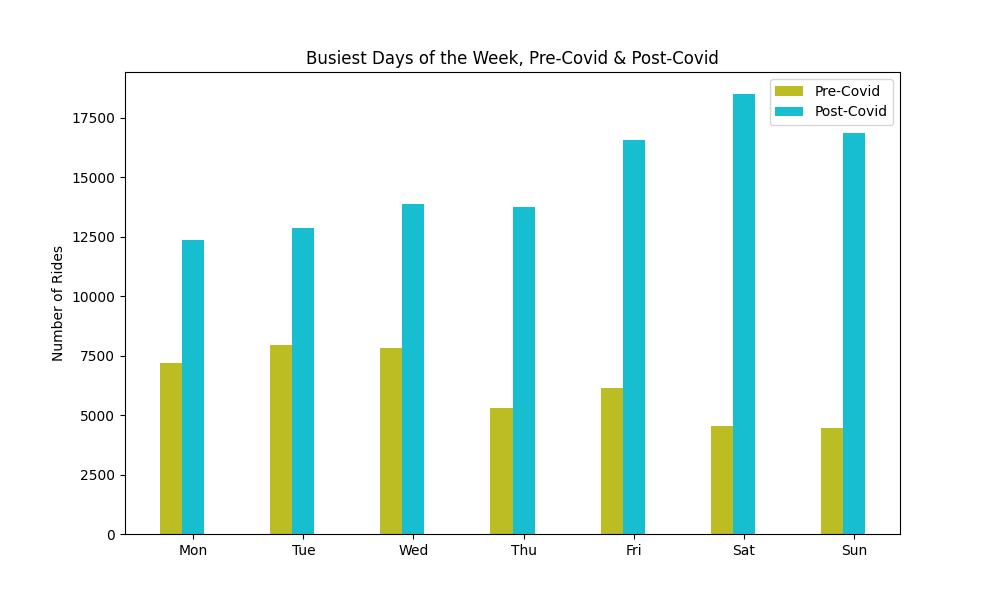

In [55]:
# Create data for 2019
busiest_day_2019 = pre_nf.select('index', date_format('started_at', 'E').alias('day_of_week'))
day_counts_2019 = busiest_day_2019.groupBy('day_of_week').count().sort(desc('count'))

# Create data for 2022
busiest_day_2022 = post_nf.select('index', date_format('started_at', 'E').alias('day_of_week'))
day_counts_2022 = busiest_day_2022.groupBy('day_of_week').count().sort(desc('count'))

# convert to Pandas dataframe
day_counts_2019df = day_counts_2019.toPandas()
day_counts_2022df = day_counts_2022.toPandas()

# create a list of days of the week in order
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# create a new column to store the order of the days
day_counts_2019df['order'] = day_counts_2019df['day_of_week'].apply(lambda x: days.index(x))
day_counts_2022df['order'] = day_counts_2022df['day_of_week'].apply(lambda x: days.index(x))

# sort the dataframes by the order column
day_counts_2019df = day_counts_2019df.sort_values(by='order')
day_counts_2022df = day_counts_2022df.sort_values(by='order')

# create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2

day_counts_2019pos = np.arange(len(day_counts_2019df))
day_counts_2022pos = [x + bar_width for x in day_counts_2019pos]

ax.bar(day_counts_2019pos, day_counts_2019df['count'], width=bar_width, color = c1, label='Pre-Covid')
ax.bar(day_counts_2022pos, day_counts_2022df['count'], width=bar_width, color = c2, label='Post-Covid')

ax.set_xticks(day_counts_2022pos)
ax.set_xticklabels(day_counts_2019df['day_of_week'])
ax.set_ylabel('Number of Rides')
ax.set_title('Busiest Days of the Week, Pre-Covid & Post-Covid')
ax.set_facecolor('white')
ax.legend()
plt.show()
%matplot plt

#### Busiest Day of the Week Based on Membership

In [56]:
print("---------Pre-Covid Data---------")

#Most Busiest Days of 2019 - Based on Membership
busiest_day2_2019 = pre_nf.select('index', date_format('started_at', 'E').alias('day_of_week'), 'member_casual').groupBy('day_of_week','member_casual').count()
busiest_day2_2019.show()

#Busiest day for members in 2019 = Tuesday
busiest_day2_2019.filter(busiest_day2_2019.member_casual == "member").sort(desc('count')).show()

#Busiest day for non-members in 2019 = Sunday
busiest_day2_2019.filter(busiest_day2_2019.member_casual == "casual").sort(desc('count')).show()


print("---------Post-Covid Data---------")

#Most Busiest Days of 2022 - Based on Membership
busiest_day2_2022 = post_nf.select('index', date_format('started_at', 'E').alias('day_of_week'), 'member_casual').groupBy('day_of_week','member_casual').count()
busiest_day2_2022.show()

#Busiest day for members in 2022 = Friday
busiest_day2_2022.filter(busiest_day2_2022.member_casual == "member").sort(desc('count')).show()

#Busiest day for non-members in 2022 = Saturday
busiest_day2_2022.filter(busiest_day2_2022.member_casual == "casual").sort(desc('count')).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
+-----------+-------------+-----+
|day_of_week|member_casual|count|
+-----------+-------------+-----+
|        Mon|       member| 6467|
|        Thu|       casual|  801|
|        Wed|       casual|  804|
|        Sun|       member| 3298|
|        Mon|       casual|  736|
|        Thu|       member| 4513|
|        Sat|       casual| 1150|
|        Wed|       member| 7021|
|        Tue|       casual|  818|
|        Sat|       member| 3385|
|        Fri|       member| 5366|
|        Tue|       member| 7140|
|        Sun|       casual| 1176|
|        Fri|       casual|  755|
+-----------+-------------+-----+

+-----------+-------------+-----+
|day_of_week|member_casual|count|
+-----------+-------------+-----+
|        Tue|       member| 7140|
|        Wed|       member| 7021|
|        Mon|       member| 6467|
|        Fri|       member| 5366|
|        Thu|       member| 4513|
|        Sat|       member| 3385|
|        Sun|       member| 3298|
+-----------+-

#### Busiest Day of the Week Based on Membership - Visualization

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

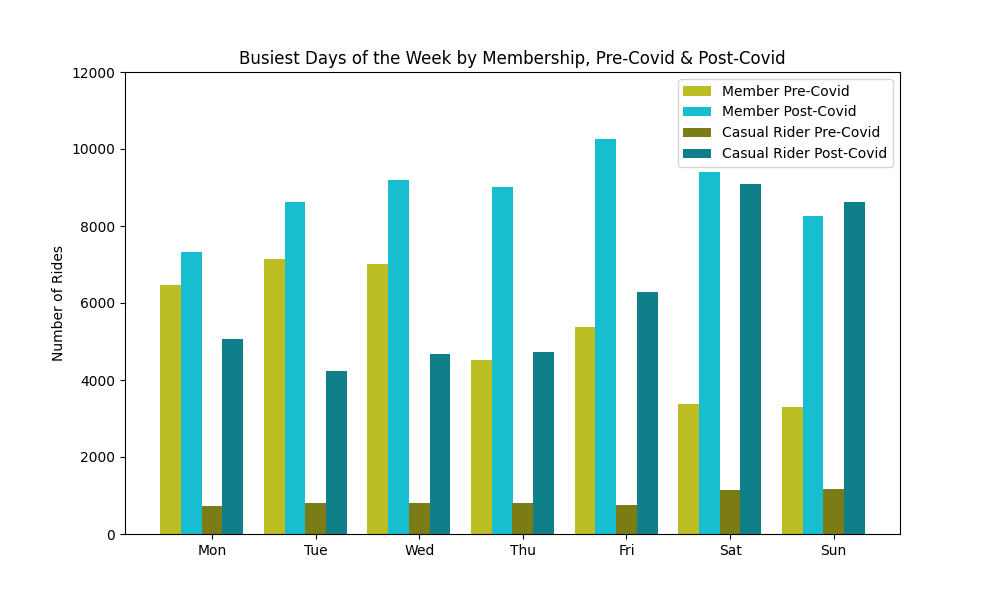

In [57]:
# filter busiest days for members 2019
busiest_members2019 = busiest_day2_2019.filter(busiest_day2_2019.member_casual == "member").sort('day_of_week')

# filter busiest days for non-members 2019
busiest_nonmembers2019 = busiest_day2_2019.filter(busiest_day2_2019.member_casual == "casual").sort('day_of_week')

# filter busiest days for members 2019
busiest_members2022 = busiest_day2_2022.filter(busiest_day2_2022.member_casual == "member").sort('day_of_week')

# filter busiest days for non-members 2019
busiest_nonmembers2022 = busiest_day2_2022.filter(busiest_day2_2022.member_casual == "casual").sort('day_of_week')

# convert to Pandas dataframe
members2019_df = busiest_members2019.toPandas()
nonmembers2019_df = busiest_nonmembers2019.toPandas()
members2022_df = busiest_members2022.toPandas()
nonmembers2022_df = busiest_nonmembers2022.toPandas()

# create a list of days of the week in order
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# create a new column to store the order of the days
members2019_df['order'] = members2019_df['day_of_week'].apply(lambda x: days.index(x))
nonmembers2019_df['order'] = nonmembers2019_df['day_of_week'].apply(lambda x: days.index(x))
members2022_df['order'] = members2022_df['day_of_week'].apply(lambda x: days.index(x))
nonmembers2022_df['order'] = nonmembers2022_df['day_of_week'].apply(lambda x: days.index(x))

# sort the dataframes by the order column
members2019_df = members2019_df.sort_values(by='order')
nonmembers2019_df = nonmembers2019_df.sort_values(by='order')
members2022_df = members2022_df.sort_values(by='order')
nonmembers2022_df = nonmembers2022_df.sort_values(by='order')

# create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2

member2019_pos = np.arange(len(members2019_df))
member2022_pos = [x + bar_width for x in member2019_pos]
nonmember2019_pos = [x + 2*bar_width for x in member2019_pos]
nonmember2022_pos = [x + 3*bar_width for x in member2019_pos]

ax.bar(member2019_pos, members2019_df['count'], width=bar_width, color=c1, label='Member Pre-Covid')
ax.bar(member2022_pos, members2022_df['count'], width=bar_width, color=c2, label='Member Post-Covid')
ax.bar(nonmember2019_pos, nonmembers2019_df['count'], width=bar_width, color=c3, label='Casual Rider Pre-Covid')
ax.bar(nonmember2022_pos, nonmembers2022_df['count'], width=bar_width, color=c4, label='Casual Rider Post-Covid')

ax.set_xticks(nonmember2019_pos)
ax.set_xticklabels(members2019_df['day_of_week'])
ax.set_ylabel('Number of Rides')
ax.set_title('Busiest Days of the Week by Membership, Pre-Covid & Post-Covid')
ax.set_facecolor('white')
plt.ylim(0, 12000)
ax.legend()
plt.show()
%matplot plt

### Busiest Time of the Day to Start a Ride

In [58]:
print("---------Pre-Covid Data---------")

#Most busiest hour of the day to start a ride in 2019 - General
busiest_time_2019 = pre_nf.select('index', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('hour_of_day').count().orderBy('count', ascending=False)

busiest_time_2019.show(1)
#Busiest hour of the day in 2019 is 800 to 900 hours i.e. 8:00am to 9:00am  


print("---------Post-Covid Data---------")

#Most busiest hour of the day to start a ride in 2022 - General
busiest_time_2022 = post_nf.select('index', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('hour_of_day').count().orderBy('count', ascending=False)

busiest_time_2022.show(1)
#Busiest hour of the day is 1800 to 1900 hours i.e. 6:00pm to 7:00pm  

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
+-----------+-----+
|hour_of_day|count|
+-----------+-----+
|          8| 4642|
+-----------+-----+
only showing top 1 row

---------Post-Covid Data---------
+-----------+-----+
|hour_of_day|count|
+-----------+-----+
|         18| 9827|
+-----------+-----+
only showing top 1 row

#### Busiest Time of the Day to Start a Ride - Visualization

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

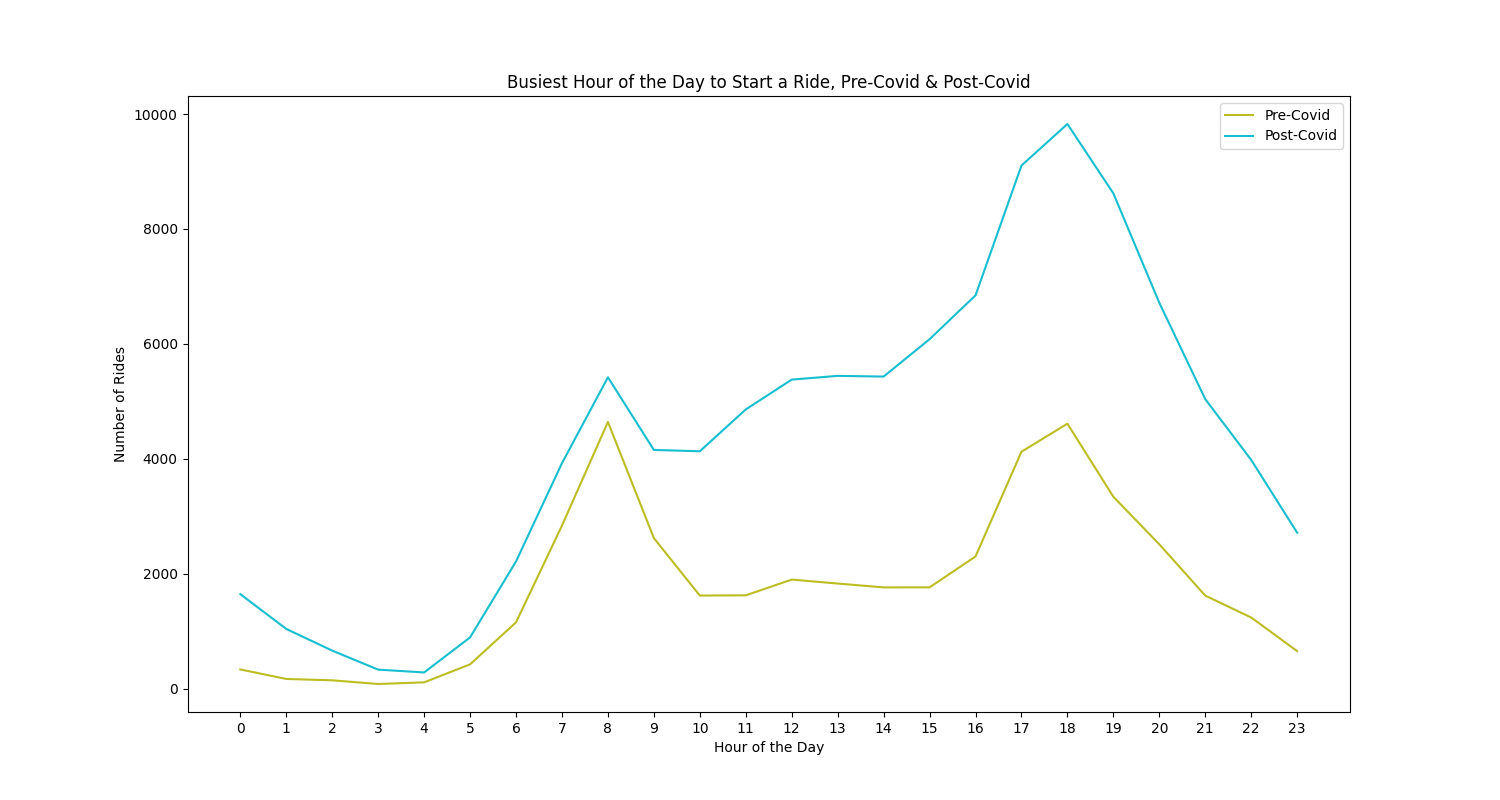

In [59]:
# Get the data
busiest_time_2019v = pre_nf.select('index', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('hour_of_day').count().orderBy('hour_of_day')
busiest_time_2022v = post_nf.select('index', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('hour_of_day').count().orderBy('hour_of_day')

# Convert the data to a list for plotting
x = busiest_time_2019v.select('hour_of_day').rdd.flatMap(lambda x: x).collect()
y2019 = busiest_time_2019v.select('count').rdd.flatMap(lambda x: x).collect()
y2022 = busiest_time_2022v.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(15,8))

# Create a line plot
plt.plot(x, y2019, label='Pre-Covid', color = c1)
plt.plot(x, y2022, label='Post-Covid', color = c2)

# Set the plot title and axis labels
plt.title('Busiest Hour of the Day to Start a Ride, Pre-Covid & Post-Covid')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')

# Set the x-axis ticks to show all 24 hours
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.show()
%matplot plt

### Busiest Time of the Day to Start a Ride Based on Membership

In [60]:
print("---------Pre-Covid Data---------")
#Most busiest time of the day to start a ride in 2019 - Based on membership
busiest_time2_2019 = pre_nf.select('member_casual', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('member_casual', 'hour_of_day').count().orderBy('count', ascending=False)

busiest_time2_2019.show()

#Busiest hour of the day for members in 2019 is 8:00am
busiest_time2_2019.filter(busiest_time2_2019.member_casual == "member").sort(desc('count')).show(1)

#Busiest hour of the day for non-members in 2019 also 7:00pm
busiest_time2_2019.filter(busiest_time2_2019.member_casual == "casual").sort(desc('count')).show(1)


print("---------Pre-Covid Data---------")
#Most busiest time of the day to start a ride in 2022 - Based on membership
busiest_time2_2022 = post_nf.select('member_casual', 'started_at').withColumn('hour_of_day', hour('started_at')).groupBy('member_casual', 'hour_of_day').count().orderBy('count', ascending=False)

busiest_time2_2022.show()

#Busiest hour of the day for members in 2022 is 6:00pm
busiest_time2_2022.filter(busiest_time2_2022.member_casual == "member").sort(desc('count')).show(1)

#Busiest hour of the day for non-members in 2022 also 6:00pm
busiest_time2_2022.filter(busiest_time2_2022.member_casual == "casual").sort(desc('count')).show(1)



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
+-------------+-----------+-----+
|member_casual|hour_of_day|count|
+-------------+-----------+-----+
|       member|          8| 4312|
|       member|         18| 4093|
|       member|         17| 3626|
|       member|         19| 2800|
|       member|          7| 2648|
|       member|          9| 2402|
|       member|         20| 2010|
|       member|         16| 1900|
|       member|         12| 1564|
|       member|         13| 1474|
|       member|         10| 1389|
|       member|         14| 1372|
|       member|         15| 1365|
|       member|         21| 1343|
|       member|         11| 1327|
|       member|          6| 1055|
|       member|         22|  985|
|       casual|         19|  540|
|       casual|         18|  519|
|       member|         23|  513|
+-------------+-----------+-----+
only showing top 20 rows

+-------------+-----------+-----+
|member_casual|hour_of_day|count|
+-------------+-----------+-----+
|       member|        

#### Busiest Time of the Day to Start a Ride Based on Membership - Visualization

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

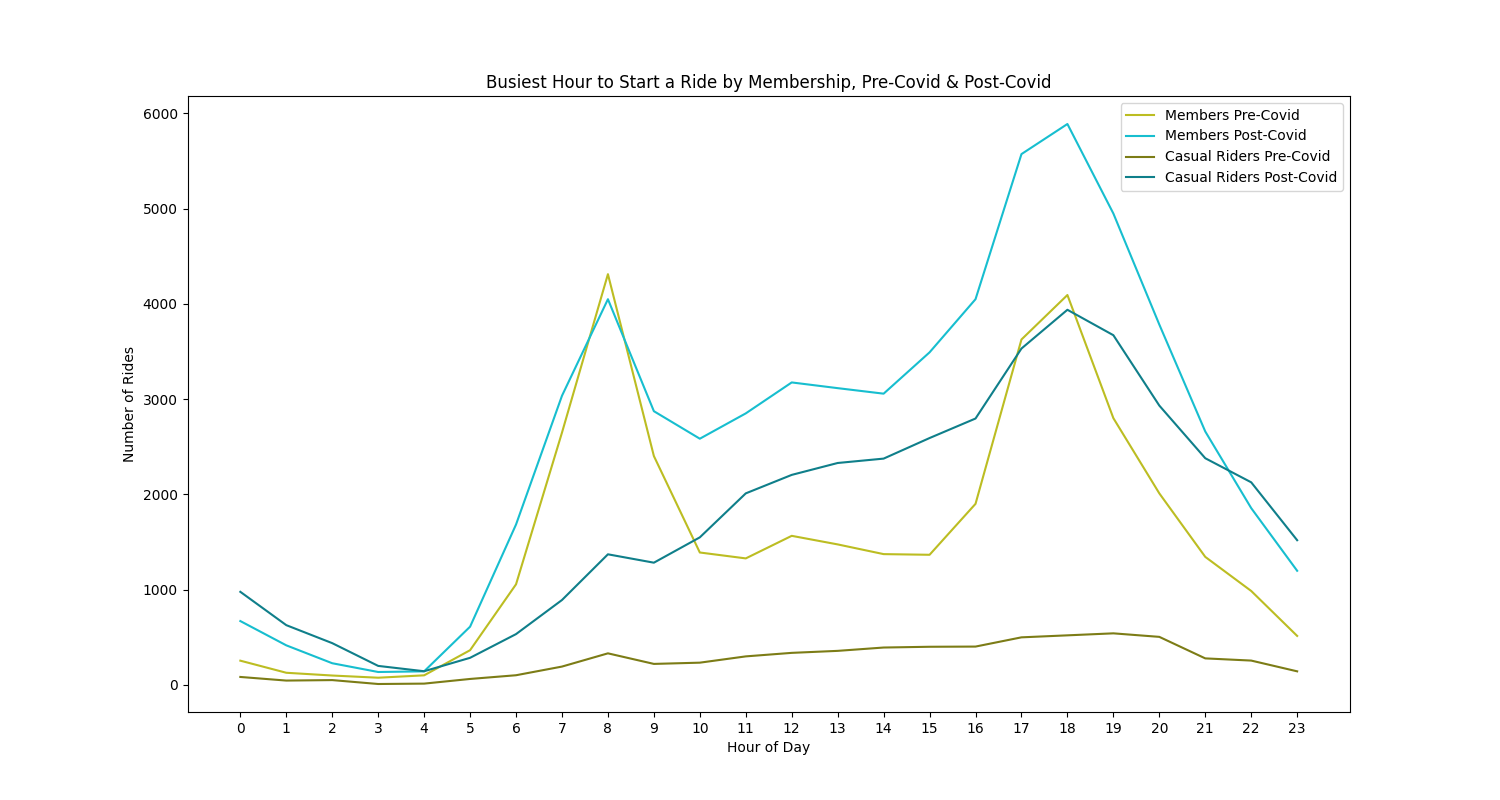

In [61]:
# Filter data for members and casual riders
members2019 = busiest_time2_2019.filter(busiest_time2_2019.member_casual == 'member')
casual2019 = busiest_time2_2019.filter(busiest_time2_2019.member_casual == 'casual')
members2022 = busiest_time2_2022.filter(busiest_time2_2022.member_casual == 'member')
casual2022 = busiest_time2_2022.filter(busiest_time2_2022.member_casual == 'casual')

# Create arrays for x-axis (hours)
hours = np.arange(0, 24)

# Create arrays for y-axis (counts)
members_count2019 = np.zeros(24)
for row in members2019.collect():
    members_count2019[row['hour_of_day']] = row['count']

casual_count2019 = np.zeros(24)
for row in casual2019.collect():
    casual_count2019[row['hour_of_day']] = row['count']
    
members_count2022 = np.zeros(24)
for row in members2022.collect():
    members_count2022[row['hour_of_day']] = row['count']

casual_count2022 = np.zeros(24)
for row in casual2022.collect():
    casual_count2022[row['hour_of_day']] = row['count']
    
plt.figure(figsize=(15,8))
    
# Plot the line chart
plt.plot(hours, members_count2019, label = 'Members Pre-Covid', color = c1)
plt.plot(hours, members_count2022, label = 'Members Post-Covid', color = c2)
plt.plot(hours, casual_count2019, label = 'Casual Riders Pre-Covid', color = c3)
plt.plot(hours, casual_count2022, label = 'Casual Riders Post-Covid', color = c4)

# Set chart title, x and y labels, and legend
plt.title('Busiest Hour to Start a Ride by Membership, Pre-Covid & Post-Covid')
plt.xlabel('Hour of Day')
plt.xticks(np.arange(0, 24))
plt.ylabel('Number of Rides')
plt.legend()

# Show the chart
plt.show()
%matplot plt

### Busiest Hour of the Day (Most Active Rides) 

In [62]:
print("---------Pre-Covid Data---------")
# Calculate the active ride time of the day
busiest_hour_2019 = pre_nf.select('index', 'started_at', 'ended_at') \
                .withColumn('start_hour', hour('started_at')) \
                .withColumn('end_hour', hour('ended_at'))
busiest_hour_2019 = busiest_hour_2019.withColumn('active', array(*[sequence(col('start_hour'), col('end_hour'))]))
busiest_hour_2019 = busiest_hour_2019.select('index', 'start_hour', 'end_hour', explode('active').alias('active'))
busiest_hour_2019.show()

active_dict2019 = {}
for row in busiest_hour_2019.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict2019:
            active_dict2019[item] = 1
        else:
            active_dict2019[item] += 1
            
active_dict2019

busiest_hour_df2019 = pd.DataFrame(list(active_dict2019.items()), columns = ['hour', 'active rides'])
busiest_hour_df2019 = busiest_hour_df2019.sort_values(by = 'hour')

print(busiest_hour_df2019)



print("---------Post-Covid Data---------")
# Calculate the active ride time of the day
busiest_hour_2022 = post_nf.select('index', 'started_at', 'ended_at') \
                .withColumn('start_hour', hour('started_at')) \
                .withColumn('end_hour', hour('ended_at'))
busiest_hour_2022 = busiest_hour_2022.withColumn('active', array(*[sequence(col('start_hour'), col('end_hour'))]))
busiest_hour_2022 = busiest_hour_2022.select('index', 'start_hour', 'end_hour', explode('active').alias('active'))
busiest_hour_2022.show()

active_dict2022 = {}
for row in busiest_hour_2022.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict2022:
            active_dict2022[item] = 1
        else:
            active_dict2022[item] += 1
            
active_dict2022

#Convert dictionary to pandas dataframe
busiest_hour_df2022 = pd.DataFrame(list(active_dict2022.items()), columns = ['hour', 'active rides'])
busiest_hour_df2022 = busiest_hour_df2022.sort_values(by = 'hour')

print(busiest_hour_df2022)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Pre-Covid Data---------
+-----+----------+--------+------+
|index|start_hour|end_hour|active|
+-----+----------+--------+------+
|    0|         0|       0|   [0]|
|    1|         0|       0|   [0]|
|    2|         0|       0|   [0]|
|    3|         0|       0|   [0]|
|    4|         0|       0|   [0]|
|    5|         0|       0|   [0]|
|    6|         0|       0|   [0]|
|    7|         0|       0|   [0]|
|    8|         0|       0|   [0]|
|    9|         1|       1|   [1]|
|   10|         1|       2|[1, 2]|
|   11|         1|       2|[1, 2]|
|   12|         2|       2|   [2]|
|   13|         2|       2|   [2]|
|   14|         3|       3|   [3]|
|   15|         4|       4|   [4]|
|   16|         4|       4|   [4]|
|   17|         4|       4|   [4]|
|   18|         4|       4|   [4]|
|   19|         4|       5|[4, 5]|
+-----+----------+--------+------+
only showing top 20 rows

    hour  active rides
0      0           453
1      1           338
2      2           305
3      3 

#### Busiest Hour of the Day (Most Active Rides) - Visualization

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

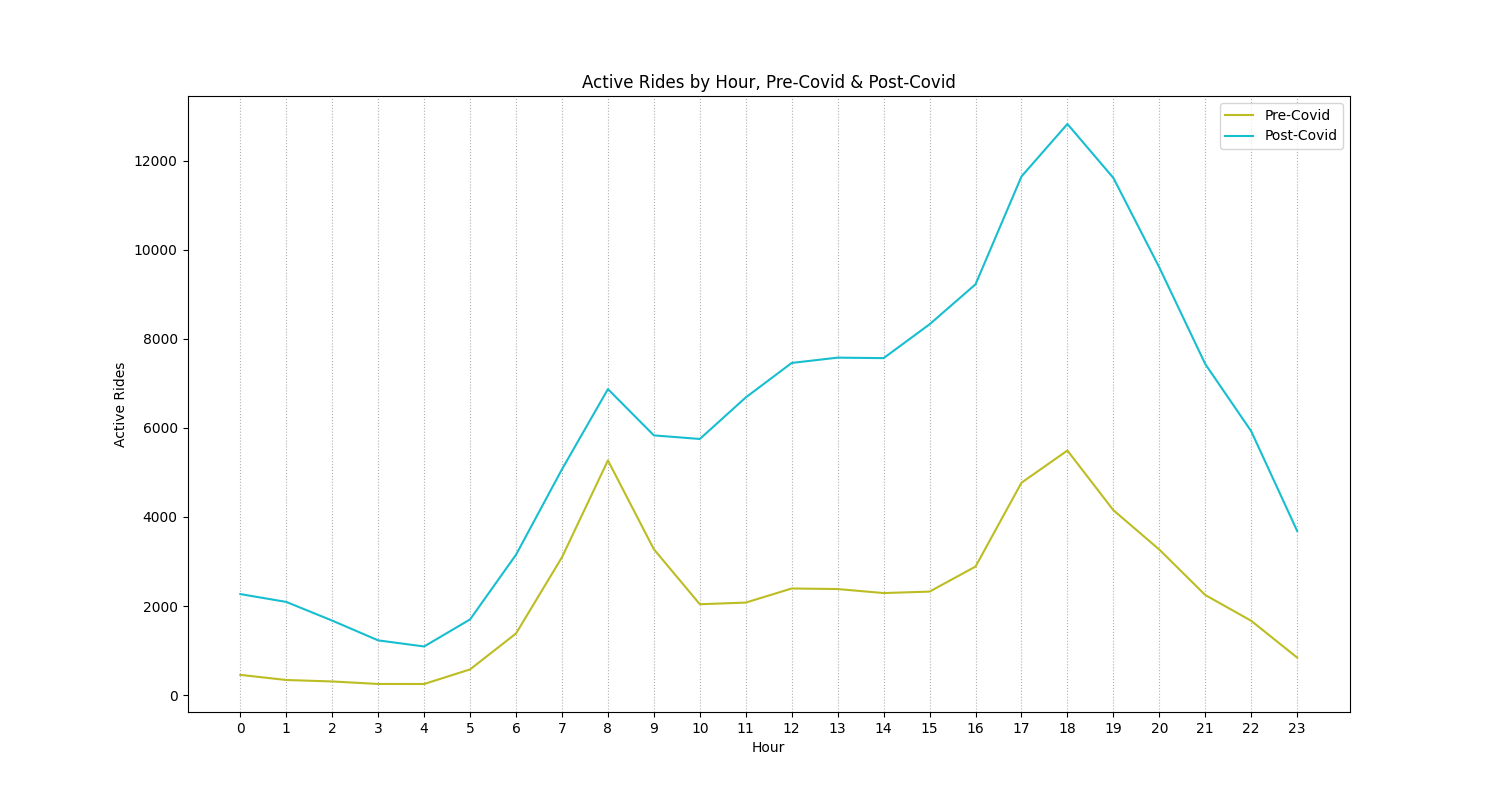

In [63]:
plt.figure(figsize=(15,8))

plt.plot(busiest_hour_df2019['hour'], busiest_hour_df2019['active rides'], label = 'Pre-Covid', color = c1)
plt.plot(busiest_hour_df2022['hour'], busiest_hour_df2022['active rides'], label = 'Post-Covid', color = c2)

plt.title('Active Rides by Hour, Pre-Covid & Post-Covid')
plt.xlabel('Hour')
plt.xticks(busiest_hour_df2019['hour'])
plt.grid(axis = 'x', linestyle = ':')
plt.ylabel('Active Rides')
plt.legend()
plt.show()
%matplot plt

#### Busiest Hour of the Day (Most Active Rides) Based on Membership

In [64]:
print("---------Post-Covid Data---------")
# Calculate the active ride time of the day
busiest_hour2_2019 = pre_nf.select('index', 'started_at', 'ended_at', 'member_casual') \
                    .withColumn('start_hour', hour('started_at')) \
                    .withColumn('end_hour', hour('ended_at'))
busiest_hour2_2019 = busiest_hour2_2019.withColumn('active', array(*[sequence(col('start_hour'), col('end_hour'))]))
busiest_hour2_2019 = busiest_hour2_2019.select('index', 'start_hour', 'end_hour', explode('active').alias('active'), 'member_casual')
busiest_hour2_2019.show()

# Filtering by members and non-members
busiest_hour_member2019 = busiest_hour2_2019.filter(busiest_hour2_2019['member_casual'] == 'member')
busiest_hour_member2019.show()

busiest_hour_nonmember2019 = busiest_hour2_2019.filter(busiest_hour2_2019['member_casual'] == 'casual')
busiest_hour_nonmember2019.show()


active_dict_member2019 = {}
for row in busiest_hour_member2019.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict_member2019:
            active_dict_member2019[item] = 1
        else:
            active_dict_member2019[item] += 1
            
active_dict_nonmember2019 = {}
for row in busiest_hour_nonmember2019.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict_nonmember2019:
            active_dict_nonmember2019[item] = 1
        else:
            active_dict_nonmember2019[item] += 1

            #Convert dictionary to pandas dataframe
busiest_hour_memberdf2019 = pd.DataFrame(list(active_dict_member2019.items()), columns = ['hour', 'active rides'])
busiest_hour_memberdf2019 = busiest_hour_memberdf2019.sort_values(by = 'hour')

print(busiest_hour_memberdf2019)
#Convert dictionary to pandas dataframe
busiest_hour_nonmemberdf2019 = pd.DataFrame(list(active_dict_nonmember2019.items()), columns = ['hour', 'active rides'])
busiest_hour_nonmemberdf2019 = busiest_hour_nonmemberdf2019.sort_values(by = 'hour')

print(busiest_hour_nonmemberdf2019)


print("---------Post-Covid Data---------")
# Calculate the active ride time of the day
busiest_hour2_2022 = post_nf.select('index', 'started_at', 'ended_at', 'member_casual') \
                    .withColumn('start_hour', hour('started_at')) \
                    .withColumn('end_hour', hour('ended_at'))
busiest_hour2_2022 = busiest_hour2_2022.withColumn('active', array(*[sequence(col('start_hour'), col('end_hour'))]))
busiest_hour2_2022 = busiest_hour2_2022.select('index', 'start_hour', 'end_hour', explode('active').alias('active'), 'member_casual')
busiest_hour2_2022.show()

# Filtering by members and non-members
busiest_hour_member2022 = busiest_hour2_2022.filter(busiest_hour2_2022['member_casual'] == 'member')
busiest_hour_member2022.show()

busiest_hour_nonmember2022 = busiest_hour2_2022.filter(busiest_hour2_2022['member_casual'] == 'casual')
busiest_hour_nonmember2022.show()


active_dict_member2022 = {}
for row in busiest_hour_member2022.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict_member2022:
            active_dict_member2022[item] = 1
        else:
            active_dict_member2022[item] += 1
            
active_dict_nonmember2022 = {}
for row in busiest_hour_nonmember2022.select('active').collect():
    active_value = row['active']
    for item in row['active']:
        if item not in active_dict_nonmember2022:
            active_dict_nonmember2022[item] = 1
        else:
            active_dict_nonmember2022[item] += 1

#Convert dictionary to pandas dataframe
busiest_hour_memberdf2022 = pd.DataFrame(list(active_dict_member2022.items()), columns = ['hour', 'active rides'])
busiest_hour_memberdf2022 = busiest_hour_memberdf2022.sort_values(by = 'hour')

print(busiest_hour_memberdf2022)
#Convert dictionary to pandas dataframe
busiest_hour_nonmemberdf2022 = pd.DataFrame(list(active_dict_nonmember2022.items()), columns = ['hour', 'active rides'])
busiest_hour_nonmemberdf2022 = busiest_hour_nonmemberdf2022.sort_values(by = 'hour')

print(busiest_hour_nonmemberdf2022)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------Post-Covid Data---------
+-----+----------+--------+------+-------------+
|index|start_hour|end_hour|active|member_casual|
+-----+----------+--------+------+-------------+
|    0|         0|       0|   [0]|       member|
|    1|         0|       0|   [0]|       member|
|    2|         0|       0|   [0]|       member|
|    3|         0|       0|   [0]|       casual|
|    4|         0|       0|   [0]|       casual|
|    5|         0|       0|   [0]|       member|
|    6|         0|       0|   [0]|       member|
|    7|         0|       0|   [0]|       member|
|    8|         0|       0|   [0]|       casual|
|    9|         1|       1|   [1]|       member|
|   10|         1|       2|[1, 2]|       casual|
|   11|         1|       2|[1, 2]|       member|
|   12|         2|       2|   [2]|       member|
|   13|         2|       2|   [2]|       member|
|   14|         3|       3|   [3]|       member|
|   15|         4|       4|   [4]|       member|
|   16|         4|       4|   [4]| 

#### Busiest Hour of the Day (Most Active Rides) Based on Membership - Visualization

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

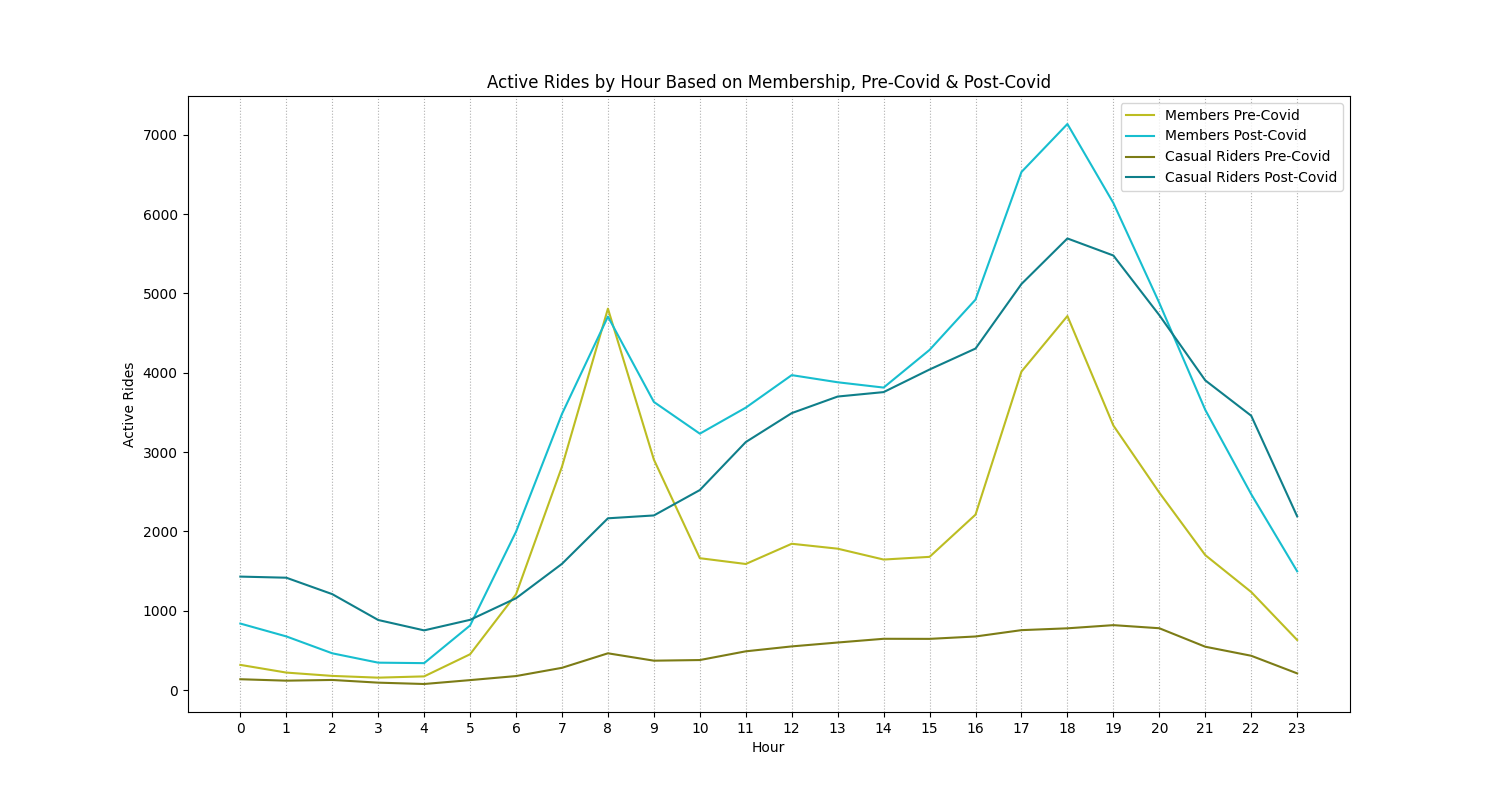

In [65]:
plt.figure(figsize=(15,8))

plt.plot(busiest_hour_memberdf2019['hour'], busiest_hour_memberdf2019['active rides'], label = 'Members Pre-Covid', color = c1)
plt.plot(busiest_hour_memberdf2022['hour'], busiest_hour_memberdf2022['active rides'], label = 'Members Post-Covid', color = c2)
plt.plot(busiest_hour_nonmemberdf2019['hour'], busiest_hour_nonmemberdf2019['active rides'], label = 'Casual Riders Pre-Covid', color = c3)
plt.plot(busiest_hour_nonmemberdf2022['hour'], busiest_hour_nonmemberdf2022['active rides'], label = 'Casual Riders Post-Covid', color = c4)

plt.title('Active Rides by Hour Based on Membership, Pre-Covid & Post-Covid')
plt.xlabel('Hour')
plt.xticks(busiest_hour_memberdf2019['hour'])
plt.grid(axis = 'x', linestyle = ':')
plt.ylabel('Active Rides')
plt.legend()
plt.show()
%matplot plt

# Test application speed (end time)

In [66]:
end_time = time.time()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Execution Time

In [67]:
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.5f} seconds")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Execution time: 268.22762 seconds